## P5.0 Data Cleaning, EDA, Feature engineering

### Foreword
1.The notebook is organised following main parts: Content overview (to facilitate navigation), data exploration & cleaning, EDA and feature engineering. Though insights will only be available through the data science steps, in lieu of the amount of details that could be derived from the dataset, a **summary overview** is provided to guide fellow readers at the start of each section.

2.The original dataset is uploaded via Large File Storage to github repo. Should the download of the dataset from git repo be unsuccessful, please download and extract the zipped version of the dataset within `assets` folder before running notebook.

---

### Introduction 
Intelligence (intel) is information that is analyzed and converted into a product to support a particular customer. In the context of counter-terrorism (CT), it has played a critical role in both offensive and defensive operations against terrorism ("Intelligence and Its Role in Protecting Against Terrorism, Richard J. H").  The intel may contain information on the pepertrator's motives. Motivation and motives are different (ref:"Countering Terrorism, Psychosocial Stratgies", Manas K.Mandal). Motivation is the general hypothesized internal state that drives a terrorist to certain deeds. Motives of terrorists are more specifc and refer to actual operations.

In CT operations, the intel community uses a data-driven approach to countering terrorism. Intel analysts analyse all available data to decipher terror activities (intended targets, time and location of attacks, attack modes) so as to better inform CT ops in the near-time and pre-emptive measures for the long term. The volume of intel data available has increased exponentially with increasingly digital connectivity. The intel analyst may face challenges with this increase in data. From literature, terrorists tend to favour bombing tactics to achieve their goals. 

**A classifier model to read in the motive of the terror group and classify the type of expected attack modes would alleviate the intel analyst's workload. For the project, we will use the `motive` data from the GTD for binary classification of `attackmode` (bombing or not_bombing).** 

### Content
- [Data Exploration](#Data-Exploration)
- [Data Cleaning](#Data-Cleaning)
- [Data dictionary (Cleaned dataset)](#Data-dictionary-(Cleaned-dataset))
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Incidents by the years](#Incidents-by-the-years)
- [Incidents by the Groups](#Incidents-by-the-Groups)
- [Incidents by Modulus Operandi](#Incidents-by-Modulus-Operandi)
- [Incidents by Geography](#Incidents-by-Geography)
- [Incidents by Motive (WordArt)](#Incidents-by-Motive-(WordArt))
- [EDA (Keywords)](#EDA-(Keywords))
- [spaCy Dependency and Entity Recognition](#spaCy-Dependency-and-Entity-Recognition)
- [Feature Engineering](#Feature-Engineering)

### Data Exploration

- The Global Terrorim Dataset (GTD) consists of terror incidents around the world from 1970 to 2017 (47 years).
- 181,691 incidents with 135 features describing broadly, the time (year,month,day), location (Region, Country, City, Province), incident (success or not, suicide attempt or not), pepertrator (name, motive, attack modes, weaponry, lone-wolf/affliated to group), target (name, type, nationality), number of killed/wounded, property damage and whether incident is related to other incidents.
- Due to shifts in data collection methods over the years, several features are added only after 1997. Owning to challenges in  backdating, missing values in these features numbered more than 100,000.
- The GTD codebook (data dictionary) provided valuable contextual information on the data fields and is pivotal in helping sense-make and decide on approaches to datacleaning and feature selection.
- Of the 181,691 incidents, 138,905 (76%) are confirmed terror incidents. Our subsequent analysis will focus on confirmed incidents.
- Decisions on datacleaning are discussed in-depth in-situ downstream.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Setting - display all columns
pd.set_option('display.max_columns', None)

ISO 8859-1 encodes what it refers to as "Latin alphabet no. 1", consisting of 191 characters from the Latin script. This character-encoding scheme is used throughout the Americas, Western Europe, Oceania, and much of Africa. It is also commonly used in most standard romanizations of East-Asian languages. - wikipedia

In [3]:
df = pd.read_csv('../assets/globalterrorismdb_0718dist.csv',encoding="ISO-8859-1")

In [4]:
# Define function for basic eda

def data_explore(df):
    #First two rows
    print("First two rows of data:")
    display(df.head(2))
    print()
    # Print shape of dataframe
    print(f"Shape: {df.shape}")
    print()
    # Print datatypes
    print("Columns & Datatypes: ")
    df.info()
    print()
    # Check for null values
    print("Null values:")
    if df.isnull().values.any() == False:
        print("None in Dataframe.")
    else:
        for col in df:
            print(f"{col}:{df[col].isnull().sum()}")
    print()
    # Count of distinct values
    print("Unique values (by Columns)")
    for col in df:
        print(f"{col}:{len(df[col].unique().tolist())}")
    print()
    # Inform if there are duplicates, if any
    if df.duplicated(subset=None, keep='first').any() == False:
      print("No duplicates present.")
    else:
        dup = df[df.duplicated(subset=None, keep='first')]
        print(f"{len(dup)} duplicates in {len(df)} rows.")

In [5]:
# Explore dataset
data_explore(df)

First two rows of data:


eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   

          country_txt  region                   region_txt provstate  \
0  Dominican Republic       2  Central America & Caribbean       NaN   
1              Mexico       1                North America   Federal   

            city   latitude  longitude  specificity  vicinity location  \
0  Santo Domingo  18.456792 -69.951164          1.0         0      NaN   
1    Mexico city  19.371887 -99.086624          1.0         0      NaN   

  summary  crit1  crit2  crit3  doubtterr  alternative alternative_txt  \
0     NaN      1      1      1        0.0          NaN             NaN   
1     NaN      1      1      1        0.0          NaN             NaN   

   multiple  success  suicide  attacktype1              attacktype1_txt  \
0       0.0        1        0            1                Assassination   
1       0.0        1        0            6  Hostage Taking (Kidnapping)   

   attacktype2 attacktype2_txt  attacktype3 attacktype3_txt  targtype1  \
0          NaN             NaN          NaN             NaN         14   
1          NaN             NaN          NaN             NaN          7   

                 targtype1_txt  targsubtype1  \
0  Private Citizens & Property          68.0   
1      Government (Diplomatic)          45.0   

                                    targsubtype1_txt  \
0                                     Named Civilian   
1  Diplomatic Personnel (outside of embassy, cons...   

                         corp1                  target1  natlty1  \
0                          NaN             Julio Guzman     58.0   
1  Belgian Ambassador Daughter  Nadine Chaval, daughter     21.0   

          natlty1_txt  targtype2 targtype2_txt  targsubtype2 targsubtype2_txt  \
0  Dominican Republic        NaN           NaN           NaN              NaN   
1             Belgium        NaN           NaN           NaN              NaN   

  corp2 target2  natlty2 natlty2_txt  targtype3 targtype3_txt  targsubtype3  \
0   NaN     NaN      NaN         NaN        NaN           NaN           NaN   
1   NaN     NaN      NaN         NaN        NaN           NaN           NaN   

  targsubtype3_txt corp3 target3  natlty3 natlty3_txt  \
0              NaN   NaN     NaN      NaN         NaN   
1              NaN   NaN     NaN      NaN         NaN   

                                gname gsubname gname2 gsubname2 gname3  \
0                              MANO-D      NaN    NaN       NaN    NaN   
1  23rd of September Communist League      NaN    NaN       NaN    NaN   

  gsubname3 motive  guncertain1  guncertain2  guncertain3  individual  nperps  \
0       NaN    NaN          0.0          NaN          NaN           0     NaN   
1       NaN    NaN          0.0          NaN          NaN           0     7.0   

   nperpcap  claimed  claimmode claimmode_txt  claim2  claimmode2  \
0       NaN      NaN        NaN           NaN     NaN         NaN   
1       NaN      NaN        NaN           NaN     NaN         NaN   

  claimmode2_txt  claim3  claimmode3 claimmode3_txt  compclaim  weaptype1  \
0            NaN     NaN         NaN            NaN        NaN         13   
1            NaN     NaN         NaN            NaN        NaN         13   

  weaptype1_txt  weapsubtype1 weapsubtype1_txt  weaptype2 weaptype2_txt  \
0       Unknown           NaN              NaN        NaN           NaN   
1       Unknown           NaN              NaN        NaN           NaN   

   weapsubtype2 weapsubtype2_txt  weaptype3 weaptype3_txt  weapsubtype3  \
0           NaN              NaN        NaN           NaN           NaN   
1           NaN              NaN        NaN           NaN           NaN   

  weapsubtype3_txt  weaptype4 weaptype4_txt  weapsubtype4 weapsubtype4_txt  \
0              NaN        NaN           Na


Shape: (181691, 135)

Columns & Datatypes: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB

Null values:
eventid:0
iyear:0
imonth:0
iday:0
approxdate:172452
extended:0
resolution:179471
country:0
country_txt:0
region:0
region_txt:0
provstate:421
city:434
latitude:4556
longitude:4557
specificity:6
vicinity:0
location:126196
summary:66129
crit1:0
crit2:0
crit3:0
doubtterr:1
alternative:152680
alternative_txt:152680
multiple:1
success:0
suicide:0
attacktype1:0
attacktype1_txt:0
attacktype2:175377
attacktype2_txt:175377
attacktype3:181263
attacktype3_txt:181263
targtype1:0
targtype1_txt:0
targsubtype1:10373
targsubtype1_txt:10373
corp1:42550
target1:636
natlty1:1559
natlty1_txt:1559
targtype2:170547
targtype2_txt:170547
targsubtype2:171006
targsubtype2_txt:171006
corp2:171574
target2:170671
natlty2:170863
natlty2_txt:170863
targtype3:180515
targtype3_t

Observe the significant missing information for some of the columns. Conduct a first round of screening for 
- columns with approx. 50% missing values (i.e. 100000 missing values)
- review context of these columns
- potential implications of dropping these columns

In [6]:
for col in df:
    if df[col].isnull().sum()>100000:
        print(col)

approxdate
resolution
location
alternative
alternative_txt
attacktype2
attacktype2_txt
attacktype3
attacktype3_txt
targtype2
targtype2_txt
targsubtype2
targsubtype2_txt
corp2
target2
natlty2
natlty2_txt
targtype3
targtype3_txt
targsubtype3
targsubtype3_txt
corp3
target3
natlty3
natlty3_txt
gsubname
gname2
gsubname2
gname3
gsubname3
motive
guncertain2
guncertain3
claimmode
claimmode_txt
claim2
claimmode2
claimmode2_txt
claim3
claimmode3
claimmode3_txt
compclaim
weaptype2
weaptype2_txt
weapsubtype2
weapsubtype2_txt
weaptype3
weaptype3_txt
weapsubtype3
weapsubtype3_txt
weaptype4
weaptype4_txt
weapsubtype4
weapsubtype4_txt
propextent
propextent_txt
propvalue
propcomment
nhostkid
nhostkidus
nhours
ndays
divert
kidhijcountry
ransom
ransomamt
ransomamtus
ransompaid
ransompaidus
ransomnote
hostkidoutcome
hostkidoutcome_txt
nreleased
addnotes
scite2
scite3
related


This section records the insights from the GTD codebook (datadict) and analysis on these columns.

- `approxdate` - records date where exact date is unknown; redundant with iyear,imonth,idate
- `resolution` - numeric date for resolution of incident more than 24 hours. Data on whether incident is more than 24 hours `extended` suffice.
- `location` - additional info on incident location. `latitude` and `longitude` suffice.
- `alternative` - Supplemental info on category other than terrorism. Not critical to our model needs.
- `alternative_txt` - see above.
- `attacktype2` - Categorical. Based on attack type hierarchy and definitions. attacktype1 data suffice.
- `attacktype2_txt` - Supporting info. see above.
- `attacktype3` - see above.
- `attacktype3_txt` - see above.
- `targtype2` - secondary victim info. Primary target info `targtype1` suffice.
- `targtype2_txt` - see above.
- `targsubtype2` - see above.
- `targsubtype2_txt` - see above.
- `corp2`- name of secondary corporate entity targetted, Primary corp target info `corp1` suffice.
- `target2` - name of secondary victim. Primary target info `target1` suffice.
- `natlty2` - secondary victim info. Primary target info `natlty1` suffice.
- `natlty2_txt` - see above.
- `targtype3` - secondary victim info. Primary target info `targtype1` suffice.
- `targtype3_txt` - see above.
- `targsubtype3` - see above.
- `targsubtype3_txt` - see above.
- `corp3` - name of secondary corporate entity targetted, Primary corp target info `corp1` suffice.
- `target3` - name of secondary victim. Primary target info `target1` suffice.
- `natlty3` - secondary victim info. Primary target info `natlty1` suffice.
- `natlty3_txt` - see above.
- `gsubname` - additional info on prepetrator group name. `gname` suffice.
- `gname2` - see above.
- `gsubname2`- see above.
- `gname3` - see above.
- `gsubname3` - see above.
- `motive` - general information about the political, social, or economic climate at the time of the attack if considered relevant to the motivation underlying the incident. While missing 131130 values, this field is only systematically available with incidents occuring after 1997. Motive is one of the more significant feature in understanding and explaining pepertrator's actions. **The column retained for modelling purpose. Theorectically, we would use 181691 - 131130 = 50561 enteries for modeling.**
- `guncertain2` - indicates whether info source about pepertrator is based on speculation. Primary info `guncertain1` suffice.
- `guncertain3` - see above.
- `claimmode` - mode for claim of responsibility by pepertrator. Other info such as group name `gname` suffice.
- `claimmode_txt` - see above.
- `claim2` - see above.
- `claimmode2` - see above.
- `claimmode2_txt` - see above.
- `claim3` - see above.
- `claimmode3` - see above.
- `claimmode3_txt` - see above.
- `compclaim` - see above.
- `weaptype2` - secondary weapon type used. Primary weapontype info `weaptype1` suffice.
- `weaptype2_txt` - see above.
- `weapsubtype2` - see above.
- `weapsubtype2_txt` - see above.
- `weaptype3` - see above.
- `weaptype3_txt` - see above.
- `weapsubtype3` - see above.
- `weapsubtype3_txt` - see above.
- `weaptype4` - see above.
- `weaptype4_txt` - see above.
- `weapsubtype4` - see above.
- `weapsubtype4_txt` - see above.
- `propextent` - extent of property damage by monetary value. Proxy data on property damage `property` suffice.
- `propextent_txt` - see above.
- `propvalue` - see above.
- `propcomment`- see above.
- `nhostkid` - number of hostages. Not used
- `nhostkidus` - number of hostages for kidnapping in US. Not used.
- `nhours` - hours of hostage event. Not used.
- `ndays` - number of hostage event days if more than 24 hours. Not used.
- `divert` - Country that hijackers diverted vehicle to. Not relevant for project scope.
- `kidhijcountry` - Country in which hijack resolved. Not relevant for project scope.
- `ransom` - Categorical, random demanded Yes: 1, No: 0, Unknown: -9, Not applicable = NULL Not used.
- `ransomamt` - Randsom amount demanded (USD). "-99" for unknown amount. Not used.
- `ransomamtus` - Randsom amount demanded from US sources (USD). "-99" for unknown amount. Not used.
- `ransompaid` - Randsom amount paid (USD). "-99" for unknown amount. Chose to keep for EDA. Not used.
- `ransompaidus` - Randsom amount paid by US sources (USD). "-99" for unknown amount. Not used.
- `ransomnote` - Any other details relating to ransom. Ransom-related info from other columns suffice.
- `hostkidoutcome` - Categorical. Outcome of hostage events. Not used.
- `hostkidoutcome_txt` - Supporting text; can be dropped.
- `nreleased` - hostages released. Not used.
- `addnotes` - supplemental info, other columns suffice.
- `scite2` - secondary data source citation, can be dropped.
- `scite3` - see above.
- `related` - If attack is part of coordinated, multi-part incidents, additional text information is listed here. Present only after 1997. Chose to drop.

In [7]:
# Create a copy of dataframe
df2 = df.copy()

In [8]:
# Col for more than 10000 missing values
features_1 = [col for col in df2.columns if df2[col].isnull().sum()>100000] 
# index of columns to retain
id_keep1 = [30,72]
# list of columns to drop
features_drop1 = [v for i, v in enumerate(features_1) if i not in id_keep1]

In [9]:
# Drop columns discussed
df2.drop(features_drop1,axis=1,inplace=True)

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 60 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   eventid           181691 non-null  int64  
 1   iyear             181691 non-null  int64  
 2   imonth            181691 non-null  int64  
 3   iday              181691 non-null  int64  
 4   extended          181691 non-null  int64  
 5   country           181691 non-null  int64  
 6   country_txt       181691 non-null  object 
 7   region            181691 non-null  int64  
 8   region_txt        181691 non-null  object 
 9   provstate         181270 non-null  object 
 10  city              181257 non-null  object 
 11  latitude          177135 non-null  float64
 12  longitude         177134 non-null  float64
 13  specificity       181685 non-null  float64
 14  vicinity          181691 non-null  int64  
 15  summary           115562 non-null  object 
 16  crit1             18

Columns assessed to be non-relevant or redundant for eda and modelling. 
- `extended` - whether the incident lasts more than 24 hours.
- `provstate` - name of subnational admin region where attack occurs.
- `city` - city where attack occurs.
- `specificity` - geospatial resolution of lat and long fields.
- `vicinity` - whether attacks occurred in city or immediate vicinity of city.
- `summary` - Redundant info.

`doubtterr`- doubt as to whether terrorist incident fulfills all three criterion.

- `multiple` - whether incident is part of multiple incident.
- `targsubtype1` - `targtype1` level info suffice. 
- `targsubtype1_txt` - see above.
- `target1` - see above
- `corp1` - see above
- `natlty1` - redundant
- `guncertain1` - non-relevant
- `nperps` - too many unknown (-99) and missing values to be useful.
- `nperpcap` - too many unknown (-99) and missing values to be useful.
- `claimed` - not relevant
- `weapsubtype1` - `weaptype1` info sufficient
- `weapsubtype1_txt` - see above 
- `weapdetail` - see above
- `nkillus` - covered by `nkill`
- `nkillter` - covered by `nkill`
- `nwoundus` - covered by `nwound`
- `nwoundte` - covered by `nwound`
- `ishostkid` - non-relevant
- `nreleased` - non-relevant
- `scite1` - first source citation; non-relevant
- `dbsource` - data source; non-relevant
- `INT_LOG`,`INT_IDEO`,`INT_MISC`,`INT_ANY` - non-relevant

In [11]:
# Col for more than 10000 missing values
features_2 = [col for col in df2.columns] 
# index of columns to drop
id_drop1 = [4,9,10,13,14,15,20,27,28,29,30,31,35,37,38,39,42,43,44,46,47,49,50,52,53,54,55,56,57,58,59]
# list of columns to drop
features_drop2 = [v for i, v in enumerate(features_2) if i in id_drop1]

In [12]:
# Drop columns discussed
df2.drop(features_drop2,axis=1,inplace=True)

In [13]:
# Restrict analysis to only confirmed terrorist incidence
print(f"Rows in full dataset: {df2.shape[0]}")
df2 = df2[(df2['doubtterr'] == 0)]
print(f"Confirmed incidences: {df2.shape[0]}")

Rows in full dataset: 181691
Confirmed incidences: 138905


In [14]:
# Sanity check
df2.describe(include='all')

eventid          iyear         imonth           iday  \
count   1.389050e+05  138905.000000  138905.000000  138905.000000   
unique           NaN            NaN            NaN            NaN   
top              NaN            NaN            NaN            NaN   
freq             NaN            NaN            NaN            NaN   
mean    2.004031e+11    2003.965307       6.461358      15.519139   
std     1.287027e+09      12.870088       3.395801       8.807846   
min     1.970000e+11    1970.000000       0.000000       0.000000   
25%     1.992072e+11    1992.000000       4.000000       8.000000   
50%     2.010072e+11    2010.000000       6.000000      15.000000   
75%     2.014101e+11    2014.000000       9.000000      23.000000   
max     2.017123e+11    2017.000000      12.000000      31.000000   

              country country_txt         region                  region_txt  \
count   138905.000000      138905  138905.000000                      138905   
unique            NaN         202            NaN                          12   
top               NaN        Iraq            NaN  Middle East & North Africa   
freq              NaN       21695            NaN                       39396   
mean       130.369144         NaN       7.239516                         NaN   
std        111.912736         NaN       2.852969                         NaN   
min          4.000000         NaN       1.000000                         NaN   
25%         78.000000         NaN       6.000000                         NaN   
50%         97.000000         NaN       6.000000                         NaN   
75%        160.000000         NaN      10.000000                         NaN   
max       1004.000000         NaN      12.000000                         NaN   

             latitude      longitude          crit1          crit2  \
count   136025.000000  136025.000000  138905.000000  138905.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean        23.873462      30.651849       0.999942       0.999964   
std         18.290887      55.959442       0.007589       0.006000   
min        -53.154613    -157.858333       0.000000       0.000000   
25%         11.840929       8.737554       1.000000       1.000000   
50%         31.637821      44.002258       1.000000       1.000000   
75%         34.599868      69.147011       1.000000       1.000000   
max         74.633553     179.366667       1.000000       1.000000   

                crit3  doubtterr        success        suicide    attacktype1  \
count   138905.000000   138905.0  138905.000000  138905.000000  138905.000000   
unique            NaN        NaN            NaN            NaN            NaN   
top               NaN        NaN            NaN            NaN            NaN   
freq              NaN        NaN            NaN            NaN            NaN   
mean         0.999906        0.0       0.882546       0.038494       3.232814   
std          0.009674        0.0       0.321962       0.192386       1.810077   
min          0.000000        0.0       0.000000       0.000000       1.000000   
25%          1.000000        0.0       1.000000       0.000000       2.000000   
50%          1.000000        0.0       1.000000       0.000000       3.000000   
75%          1.000000        0.0       1.000000       0.000000       3.000000   
max          1.000000        0.0       1.000000       1.000000       9.000000   

          attacktype1_txt      targtype1                targtype1_txt  \
count              138905  138905.000000                       138905   
unique                  9            NaN                           22   
top     Bombing/Explosion            NaN  Private Citizens & Property   
freq                74075            NaN                        37314   
mean                  NaN       9.135719    

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138905 entries, 0 to 181690
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   eventid          138905 non-null  int64  
 1   iyear            138905 non-null  int64  
 2   imonth           138905 non-null  int64  
 3   iday             138905 non-null  int64  
 4   country          138905 non-null  int64  
 5   country_txt      138905 non-null  object 
 6   region           138905 non-null  int64  
 7   region_txt       138905 non-null  object 
 8   latitude         136025 non-null  float64
 9   longitude        136025 non-null  float64
 10  crit1            138905 non-null  int64  
 11  crit2            138905 non-null  int64  
 12  crit3            138905 non-null  int64  
 13  doubtterr        138905 non-null  float64
 14  success          138905 non-null  int64  
 15  suicide          138905 non-null  int64  
 16  attacktype1      138905 non-null  int6

### Data Cleaning

- `latitude` and `longitude` (float) Missing values for some. To drop these (2880/138905 = 2% of current dataset) after replace NaN for other columns.
- `motive` (object) to replace NaN values with 'Unknown'.
- `natlty1_txt` (object) to replace NaN values with 'Unknown'.
- `nkill` and `nwound` (float) to fillna with median value, convert to int.
- `property` (int) replace (-9 value;unknown if property damaged due to attack) with 0. (Assume not directly attributable).

In [16]:
### Review -9 values in property
df2.loc[df2['property']==-9].head(2)

eventid  iyear  imonth  iday  country    country_txt  region  \
18  197001120002   1970       1    12      217  United States       1   
50  197002060004   1970       2     6      217  United States       1   

       region_txt   latitude  longitude  crit1  crit2  crit3  doubtterr  \
18  North America  18.379998 -65.830948      1      1      1        0.0   
50  North America  18.460791 -66.264884      1      1      1        0.0   

    success  suicide  attacktype1                 attacktype1_txt  targtype1  \
18        1        0            3               Bombing/Explosion          1   
50        1        0            7  Facility/Infrastructure Attack          2   

           targtype1_txt    natlty1_txt  \
18              Business  United States   
50  Government (General)  United States   

                                               gname  \
18                                          Strikers   
50  Armed Revolutionary Independence Movement (MIRA)   

                                    motive  individual  weaptype1  \
18                                     NaN           0          6   
50  To fight imperialism and exploitation.           0          8   

   weaptype1_txt  nkill  nwound  property  
18    Explosives    0.0     0.0        -9  
50    Incendiary    0.0     0.0        -9

In [17]:
# Check NaN in nkill and nwound
df2.loc[df2['nkill'].isnull()].head(2)

eventid  iyear  imonth  iday  country         country_txt  region  \
3   197001000002   1970       1     0       78              Greece       8   
15  197001100001   1970       1    10      499  East Germany (GDR)       9   

        region_txt  latitude  longitude  crit1  crit2  crit3  doubtterr  \
3   Western Europe  37.99749  23.762728      1      1      1        0.0   
15  Eastern Europe  52.50153  13.401851      1      1      1        0.0   

    success  suicide  attacktype1    attacktype1_txt  targtype1  \
3         1        0            3  Bombing/Explosion          7   
15        1        0            3  Bombing/Explosion          2   

              targtype1_txt    natlty1_txt      gname motive  individual  \
3   Government (Diplomatic)  United States    Unknown    NaN           0   
15     Government (General)        Germany  Commune 1    NaN           0   

    weaptype1 weaptype1_txt  nkill  nwound  property  
3           6    Explosives    NaN     NaN         1  
15          6    Explosives    NaN     NaN         0

In [18]:
# Replace NaN in motive and natlty1_txt with unknown
df2['motive'].replace(np.NaN,'Unknown', inplace=True)
df2['natlty1_txt'].replace(np.NaN,'Unknown', inplace=True)

# Replace unknown values in property
df2['property'].replace(-9,0, inplace=True)

# Replace NaN in nkill and nwound with median
df2['nkill'] = df2['nkill'].fillna(df2['nkill'].median()).astype(int)
df2['nwound'] = df2['nwound'].fillna(df2['nwound'].median()).astype(int)

In [19]:
# Check NaN in target1, natlty1_txt replaced
print(f"nNaN in motive: {df2['motive'].isnull().sum()} \nNaN in natlty1_txt: {df2['natlty1_txt'].isnull().sum()}")

# Check property -9 replaced
print(f"Check all -9 values replaced: {(df2['property']!=-9).value_counts()}")
# Check NaN in nkill and nwound replaced
print(f"NaN in nkill: {df2['nkill'].isnull().sum()} \nNaN in nwound: {df2['nwound'].isnull().sum()}")

nNaN in motive: 0 
NaN in natlty1_txt: 0
Check all -9 values replaced: True    138905
Name: property, dtype: int64
NaN in nkill: 0 
NaN in nwound: 0


In [20]:
# Drop missing values for Latitude and Longitude, assign to separate dataframe
df3 = df2.dropna(axis = 0, how ='any')
df3.shape

(136025, 29)

In [21]:
df3.head()

eventid  iyear  imonth  iday  country         country_txt  region  \
0  197000000001   1970       7     2       58  Dominican Republic       2   
1  197000000002   1970       0     0      130              Mexico       1   
2  197001000001   1970       1     0      160         Philippines       5   
3  197001000002   1970       1     0       78              Greece       8   
5  197001010002   1970       1     1      217       United States       1   

                    region_txt   latitude   longitude  crit1  crit2  crit3  \
0  Central America & Caribbean  18.456792  -69.951164      1      1      1   
1                North America  19.371887  -99.086624      1      1      1   
2               Southeast Asia  15.478598  120.599741      1      1      1   
3               Western Europe  37.997490   23.762728      1      1      1   
5                North America  37.005105  -89.176269      1      1      1   

   doubtterr  success  suicide  attacktype1              attacktype1_txt  \
0        0.0        1        0            1                Assassination   
1        0.0        1        0            6  Hostage Taking (Kidnapping)   
2        0.0        1        0            1                Assassination   
3        0.0        1        0            3            Bombing/Explosion   
5        0.0        1        0            2                Armed Assault   

   targtype1                targtype1_txt         natlty1_txt  \
0         14  Private Citizens & Property  Dominican Republic   
1          7      Government (Diplomatic)             Belgium   
2         10          Journalists & Media       United States   
3          7      Government (Diplomatic)       United States   
5          3                       Police       United States   

                                gname  \
0                              MANO-D   
1  23rd of September Communist League   
2                             Unknown   
3                             Unknown   
5                  Black Nationalists   

                                           motive  individual  weaptype1  \
0                                         Unknown           0         13   
1                                         Unknown           0         13   
2                                         Unknown           0         13   
3                                         Unknown           0          6   
5  To protest the Cairo Illinois Police Deparment           0          5   

  weaptype1_txt  nkill  nwound  property  
0       Unknown      1       0         0  
1       Unknown      0       0         0  
2       Unknown      1       0         0  
3    Explosives      0       0         1  
5      Firearms      0       0         1

Reviewing dataset, we 
- drop other columns not relevant at this stage.
- convert all text values to lower case (except country_txt and region_txt).
- rename (shorten) specific column headers.

In [22]:
# Further drop columns that are not relevant at this stage
col_drop = ['country','region','attacktype1','targtype1','weaptype1','doubtterr']
df3 = df3.drop(columns=col_drop)

# Convert text values to lowercase
df3['attacktype1_txt'] = df3['attacktype1_txt'].str.lower()
df3['targtype1_txt'] = df3['targtype1_txt'].str.lower()
df3['natlty1_txt'] = df3['natlty1_txt'].str.lower()
df3['gname'] = df3['gname'].str.lower()
df3['motive'] = df3['motive'].str.lower()
df3['weaptype1_txt'] = df3['weaptype1_txt'].str.lower()

# Shorten specific column headers
df3 = df3.rename(columns={'country_txt': 'country',\
                          'region_txt': 'region',\
                          'latitude': 'lat',\
                          'longitude': 'lon',\
                          'attacktype1_txt': 'atkmode',\
                          'targtype1_txt': 'targtype',\
                          'natlty1_txt': 'targnat',\
                          'individual': 'indiv',\
                          'weaptype1_txt': 'weaptype',\
                         })

In [23]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136025 entries, 0 to 181690
Data columns (total 23 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   eventid   136025 non-null  int64  
 1   iyear     136025 non-null  int64  
 2   imonth    136025 non-null  int64  
 3   iday      136025 non-null  int64  
 4   country   136025 non-null  object 
 5   region    136025 non-null  object 
 6   lat       136025 non-null  float64
 7   lon       136025 non-null  float64
 8   crit1     136025 non-null  int64  
 9   crit2     136025 non-null  int64  
 10  crit3     136025 non-null  int64  
 11  success   136025 non-null  int64  
 12  suicide   136025 non-null  int64  
 13  atkmode   136025 non-null  object 
 14  targtype  136025 non-null  object 
 15  targnat   136025 non-null  object 
 16  gname     136025 non-null  object 
 17  motive    136025 non-null  object 
 18  indiv     136025 non-null  int64  
 19  weaptype  136025 non-null  object 
 20  nkil

In [24]:
df3.head()

eventid  iyear  imonth  iday             country  \
0  197000000001   1970       7     2  Dominican Republic   
1  197000000002   1970       0     0              Mexico   
2  197001000001   1970       1     0         Philippines   
3  197001000002   1970       1     0              Greece   
5  197001010002   1970       1     1       United States   

                        region        lat         lon  crit1  crit2  crit3  \
0  Central America & Caribbean  18.456792  -69.951164      1      1      1   
1                North America  19.371887  -99.086624      1      1      1   
2               Southeast Asia  15.478598  120.599741      1      1      1   
3               Western Europe  37.997490   23.762728      1      1      1   
5                North America  37.005105  -89.176269      1      1      1   

   success  suicide                      atkmode                     targtype  \
0        1        0                assassination  private citizens & property   
1        1        0  hostage taking (kidnapping)      government (diplomatic)   
2        1        0                assassination          journalists & media   
3        1        0            bombing/explosion      government (diplomatic)   
5        1        0                armed assault                       police   

              targnat                               gname  \
0  dominican republic                              mano-d   
1             belgium  23rd of september communist league   
2       united states                             unknown   
3       united states                             unknown   
5       united states                  black nationalists   

                                           motive  indiv    weaptype  nkill  \
0                                         unknown      0     unknown      1   
1                                         unknown      0     unknown      0   
2                                         unknown      0     unknown      1   
3                                         unknown      0  explosives      0   
5  to protest the cairo illinois police deparment      0    firearms      0   

   nwound  property  
0       0         0  
1       0         0  
2       0         0  
3       0         1  
5       0         1

Sanity check on textual data (Categorical text descriptors should correspond with the GTD codebook).

In [25]:
# atkmode
df3['atkmode'].unique()

array(['assassination', 'hostage taking (kidnapping)',
       'bombing/explosion', 'armed assault',
       'facility/infrastructure attack', 'hijacking', 'unarmed assault',
       'hostage taking (barricade incident)', 'unknown'], dtype=object)

In [26]:
# Shorten some of the data values for atkmode
df3['atkmode'] = df3['atkmode'].replace('hostage taking (kidnapping)','hostage kidnap')
df3['atkmode'] = df3['atkmode'].replace('bombing/explosion','bombing')
df3['atkmode'] = df3['atkmode'].replace('facility/infrastructure attack','facility attack')
df3['atkmode'] = df3['atkmode'].replace('hijacking','hijack')
df3['atkmode'] = df3['atkmode'].replace('hostage taking (barricade incident)','hostage taking')
# Review update
df3['atkmode'].unique()

array(['assassination', 'hostage kidnap', 'bombing', 'armed assault',
       'facility attack', 'hijack', 'unarmed assault', 'hostage taking',
       'unknown'], dtype=object)

In [27]:
# targtype
df3['targtype'].unique()

array(['private citizens & property', 'government (diplomatic)',
       'journalists & media', 'police', 'military',
       'government (general)', 'educational institution', 'business',
       'violent political party', 'unknown', 'transportation',
       'utilities', 'airports & aircraft',
       'religious figures/institutions', 'telecommunication',
       'food or water supply', 'ngo', 'terrorists/non-state militia',
       'other', 'tourists', 'maritime', 'abortion related'], dtype=object)

In [28]:
# Shorten some of the data values for atkmode
df3['targtype'] = df3['targtype'].replace('private citizens & property','citizens and property')
df3['targtype'] = df3['targtype'].replace('government (diplomatic)','diplomats')
df3['targtype'] = df3['targtype'].replace('journalists & media','journalists')
df3['targtype'] = df3['targtype'].replace('government (general)','general')
df3['targtype'] = df3['targtype'].replace('educational institution','education')
df3['targtype'] = df3['targtype'].replace('violent political party','party')
df3['targtype'] = df3['targtype'].replace('airports & aircraft','airtransport')
df3['targtype'] = df3['targtype'].replace('religious figures/institutions','religion rep')
df3['targtype'] = df3['targtype'].replace('telecommunications','telecom')
df3['targtype'] = df3['targtype'].replace('food or water supply','food/water')
# T - terrorist, VNSA - Violent Non-State Actors
df3['targtype'] = df3['targtype'].replace('terrorists/non-state militia','T/VNSA')

# Review update
df3['targtype'].unique()

array(['citizens and property', 'diplomats', 'journalists', 'police',
       'military', 'general', 'education', 'business', 'party', 'unknown',
       'transportation', 'utilities', 'airtransport', 'religion rep',
       'telecommunication', 'food/water', 'ngo', 'T/VNSA', 'other',
       'tourists', 'maritime', 'abortion related'], dtype=object)

In [29]:
# weaptype
df3['weaptype'].unique()

array(['unknown', 'explosives', 'firearms', 'incendiary', 'chemical',
       'melee', 'sabotage equipment',
       'vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
       'fake weapons', 'radiological', 'other', 'biological'],
      dtype=object)

In [30]:
# Shorten some of the data values for atkmode
df3['weaptype'] = df3['weaptype'].replace('vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',\
                                          'vehicle')

# Review update
df3['weaptype'].unique()

array(['unknown', 'explosives', 'firearms', 'incendiary', 'chemical',
       'melee', 'sabotage equipment', 'vehicle', 'fake weapons',
       'radiological', 'other', 'biological'], dtype=object)

In [31]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136025 entries, 0 to 181690
Data columns (total 23 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   eventid   136025 non-null  int64  
 1   iyear     136025 non-null  int64  
 2   imonth    136025 non-null  int64  
 3   iday      136025 non-null  int64  
 4   country   136025 non-null  object 
 5   region    136025 non-null  object 
 6   lat       136025 non-null  float64
 7   lon       136025 non-null  float64
 8   crit1     136025 non-null  int64  
 9   crit2     136025 non-null  int64  
 10  crit3     136025 non-null  int64  
 11  success   136025 non-null  int64  
 12  suicide   136025 non-null  int64  
 13  atkmode   136025 non-null  object 
 14  targtype  136025 non-null  object 
 15  targnat   136025 non-null  object 
 16  gname     136025 non-null  object 
 17  motive    136025 non-null  object 
 18  indiv     136025 non-null  int64  
 19  weaptype  136025 non-null  object 
 20  nkil

### Data dictionary (Cleaned dataset)
- :--- or --- = left align
- ---: = right align
- :---: = centered

|Column name|Datatype|Explanation|
| ---: | :---: | :--- |
|**eventid**|*int*|Incidents from the GTD follow a 12-digit Event ID system.<br/>• First 8 numbers – date recorded “yyyymmdd”.<br/>• Last 4 numbers – sequential case number for the given day|
|**iyear, imonth, iday**|*int*|year, month, day of incidents respectively|
|**country, region**|*obj*|name of country, geographical region of incident respectivly|
|**lat, lon**|*float*|geographical coordinates of incident|
|**crit1,2,3**|*int*|Categorical variable. Inclusion criteria, allows users to filter out those incidents whose inclusion was based on a criterion which they believe does not constitute terrorism proper.<br/>• crit1: act must be aimed at attaining a political, economic, religious, or social goal.<br/>• crit2: act with intention to coerce, intimidate, or convey some other message to a larger audience (or audiences)<br/>• crit3: act is outside the context of legitimate warfare activities; targets non-combatants (i.e. the act contravenes International Humanitarian Law as reflected in the Additional Protocol to the Geneva Conventions of 12 August 1949 and elsewhere)<br/> **1** : meets criterion<br/> **0** :  does not meet criterion|
|**success**|*int*|Categorical variable. Whether or not the attack type took place.<br/> **1** : Yes<br/> **0** :  No|
|**suicide**|*int*|Categorical variable. Coded “Yes” in those cases where there is evidence that the perpetrator did not intend to escape from the attack alive. <br/>**1** : Yes<br/> **0** :  No|
|**atkmode**|*obj*|General method of attack and often reflects the broad class of tactics used. Nine categories: 'assassination', 'hostage kidnap', 'bombing', 'armed assault', 'facility attack', 'hijack', 'unarmed assault', 'hostage taking', 'unknown'.|
|**targtype, targnat,** **gname**|*obj*|- General type of target/victim. 22 categories: 'citizens and property', 'diplomats', 'journalists', 'police', 'military', 'general', 'education', 'business', 'party', 'unknown', 'transportation', 'utilities', 'airtransport', 'religion rep', 'telecommunication', 'food/water', 'ngo', 'T/VNSA', 'other', 'tourists', 'maritime', 'abortion related'.<br/>- Nationality of target<br/>- Name of group that carried out the attack|
|**motive** |*obj*|When reports explicitly mention a specific motive for the attack, this motive is recorded in the `motive` field. This field may also include general information about the political, social, or economic climate at the time of the attack if considered relevant to the motivation underlying the incident.|
|**indiv** |*int*|Categorical variable. Coded “Yes” if attack was carried out by an individual or several individuals not known to be affiliated with a group or organization alive. <br/>**1** : Yes<br/> **0** :  No|
|**weaptype**|*obj*|Categorical variable. General type of weapon used in the incident. It consists of the following categories: <br/>'unknown', 'explosives', 'firearms', 'incendiary', 'chemical', 'melee', 'sabotage equipment', 'vehicle', 'fake weapons', 'radiological', 'other', 'biological'.|
|**nkill, nwound**|*int*|Number of fatalities, Number of wounded from incident.|
|**property**|*int*|Categorical variable. Coded “Yes” if there is evidence of property damage from the incident. <br/>**1** : Yes<br/> **0** :  No|

In [32]:
# Save current cleaned dataset
# commented out to freeze data update
#df3.to_csv('../assets/terrorclean.csv')

### Exploratory Data Analysis

Owning to the legacy of the dataset, we adopt several perspectives for EDA. Top level thoughts to guide EDA.
- How have terrorist incidence varied over the years?
>A: Sharp increase in incident counts from 2012 onwards (new automated data collection, increased data source connectivity and terrorism trends). Incidences peak in 2014-2015. Highest casualties in 2001 (Sep 11 by AQ).
- Which groups inflicted most casualties?
>A: 3062 groups recorded in dataset. In terms of highest wounded by individual incidents, AQ has highest (16,000 wounded; Sep 11) followed by Aum ShirinKyo (5,500 wounded; release of sarin in metro).  
>A: Top 5 most active groups: taliban, isil, sl, boko haram, al-shabaab. Emerging in 2015, isil has highest activity rate.
>A: Top 5 groups inflicted highest casaulties: isil, taliban, AQ, boko haram, ltte.
- How have the attack modes evolved over time? Which attack mode account for highest casualties? Have target choice changed over the years? Which attack mode has highest successes?
>A: isil favored bombing, AQ conducted the least incidents, but accounted for high casualties through Sep 11. There does not appear to be a fundamental shift in the general modes of attacks over the years. Bombing remains the favored tactic, followed closely by armed assault and kidnapping in more recent years. Bombing accounts for highest casualties (total); hijacking accounts for highest average casualties.
>A: General populace and property remained top target of choice regardless of the years.
>A: Little publicized nuclear-related incidents (10 incidents in Japan by unknown perpetrator)
>A: In general, all attackmodes has more successes than failures. By proportion, since bombing has highest proportion, it also has the highest number of successes. 
- Which countries/region are the most targeted?
>A: Incidents mostly centered regions: South Asia, the Middle East & North Africa, Sub-Saharan Africa and SouthEast Asia. South Asia increasingly accounted for 50% of total yearly incidences since 2003 (due to taliban, maoist groups)
>A: Pakistan, Afgan, India, Colombia and Peru are top 5 most targeted. 
- What motives drive the tactics of terror groups?
>A: Combination of several pre-disposing factors such as social as well as ideological goals motivates terror groups. A common underlying theme is sectarian violence.

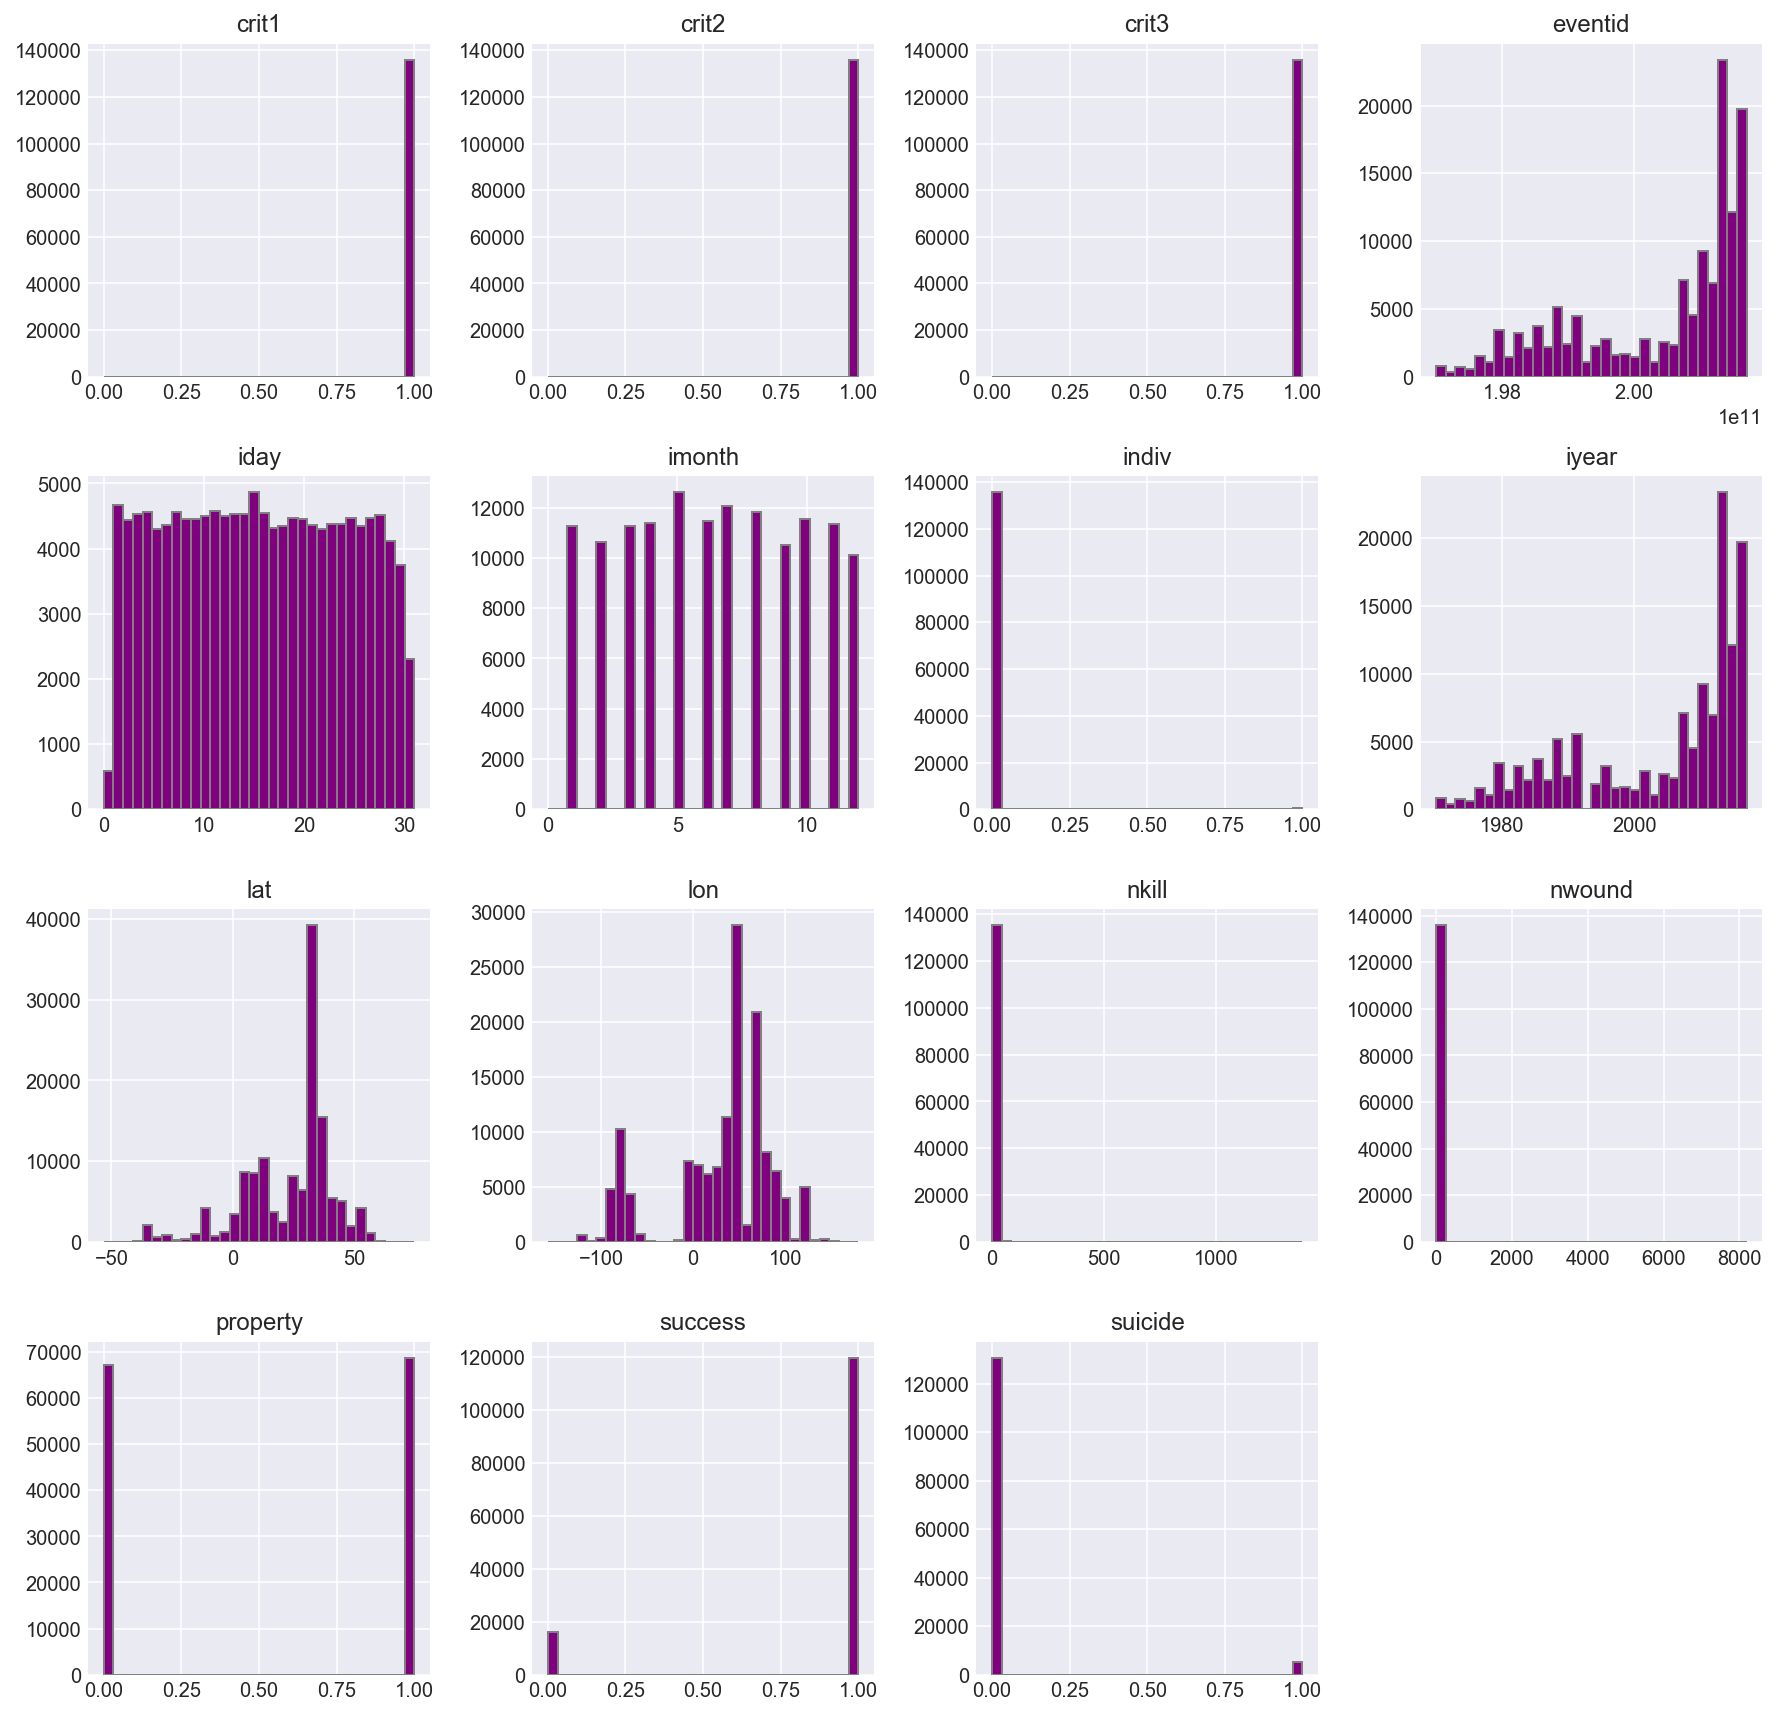

In [33]:
# Distribution of the numerical variables
df3.hist(figsize=(15, 15),bins=32,color='purple',edgecolor='grey')
plt.xticks();

Observations:
- increase in incidences post 2000 onwards.
- zero values for day and month observed, where exact day or month is unknown.
- incidences across months are generally consistent. 
- less than 10% of incidences are 'lone wolf' attacks.
- large proportion (approx. 120000/136025 = 0.88) of incidences are successfully carried out by terror groups.
- more than 90% (>120000 out of 136025 incidences) are carried out by pepertrators with no intent of surviving incident.

### Incidents by the years

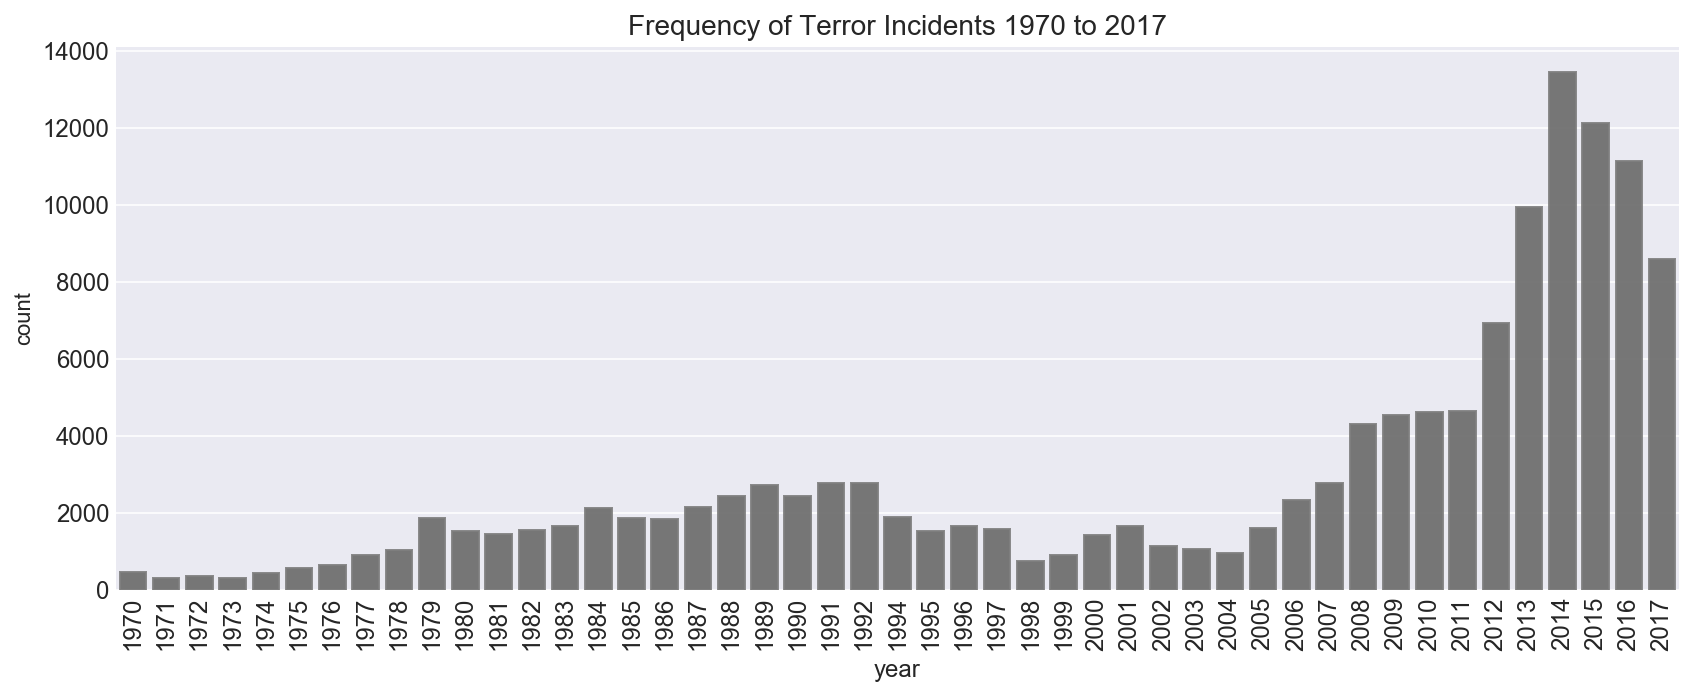

In [34]:
# Terror incidents 1970-2017
# plot
fig, ax = plt.subplots(figsize = (14,5))
sns.countplot(x='iyear',data=df3,color='dimgray',alpha=0.9, edgecolor='grey', linewidth=1)

# cutomization
plt.xlabel('year',fontsize=12)
plt.xticks(rotation=90, size=12)
plt.ylabel('count',fontsize=11)
plt.yticks(size=12)
plt.title('Frequency of Terror Incidents 1970 to 2017',size=14)
plt.show();

- 1993 data excluded from GTD (as stated in GTD codebook).
- dramatic increase in incident counts in 2012 onwards (in part due to new automated data collection, increased data source connectivity and terrorism trends)
- 2014, closely followed by 2015) saw a peak in incidences reported. (was 2014 the year with highest casualties? we'd investigate further). 

In [35]:
# Maximum fatalities and wounded of incidents
print(f" Max. fatalities: {df3['nkill'].max()}, \n Max. wounded: {df3['nwound'].max()}")

 Max. fatalities: 1384, 
 Max. wounded: 8191


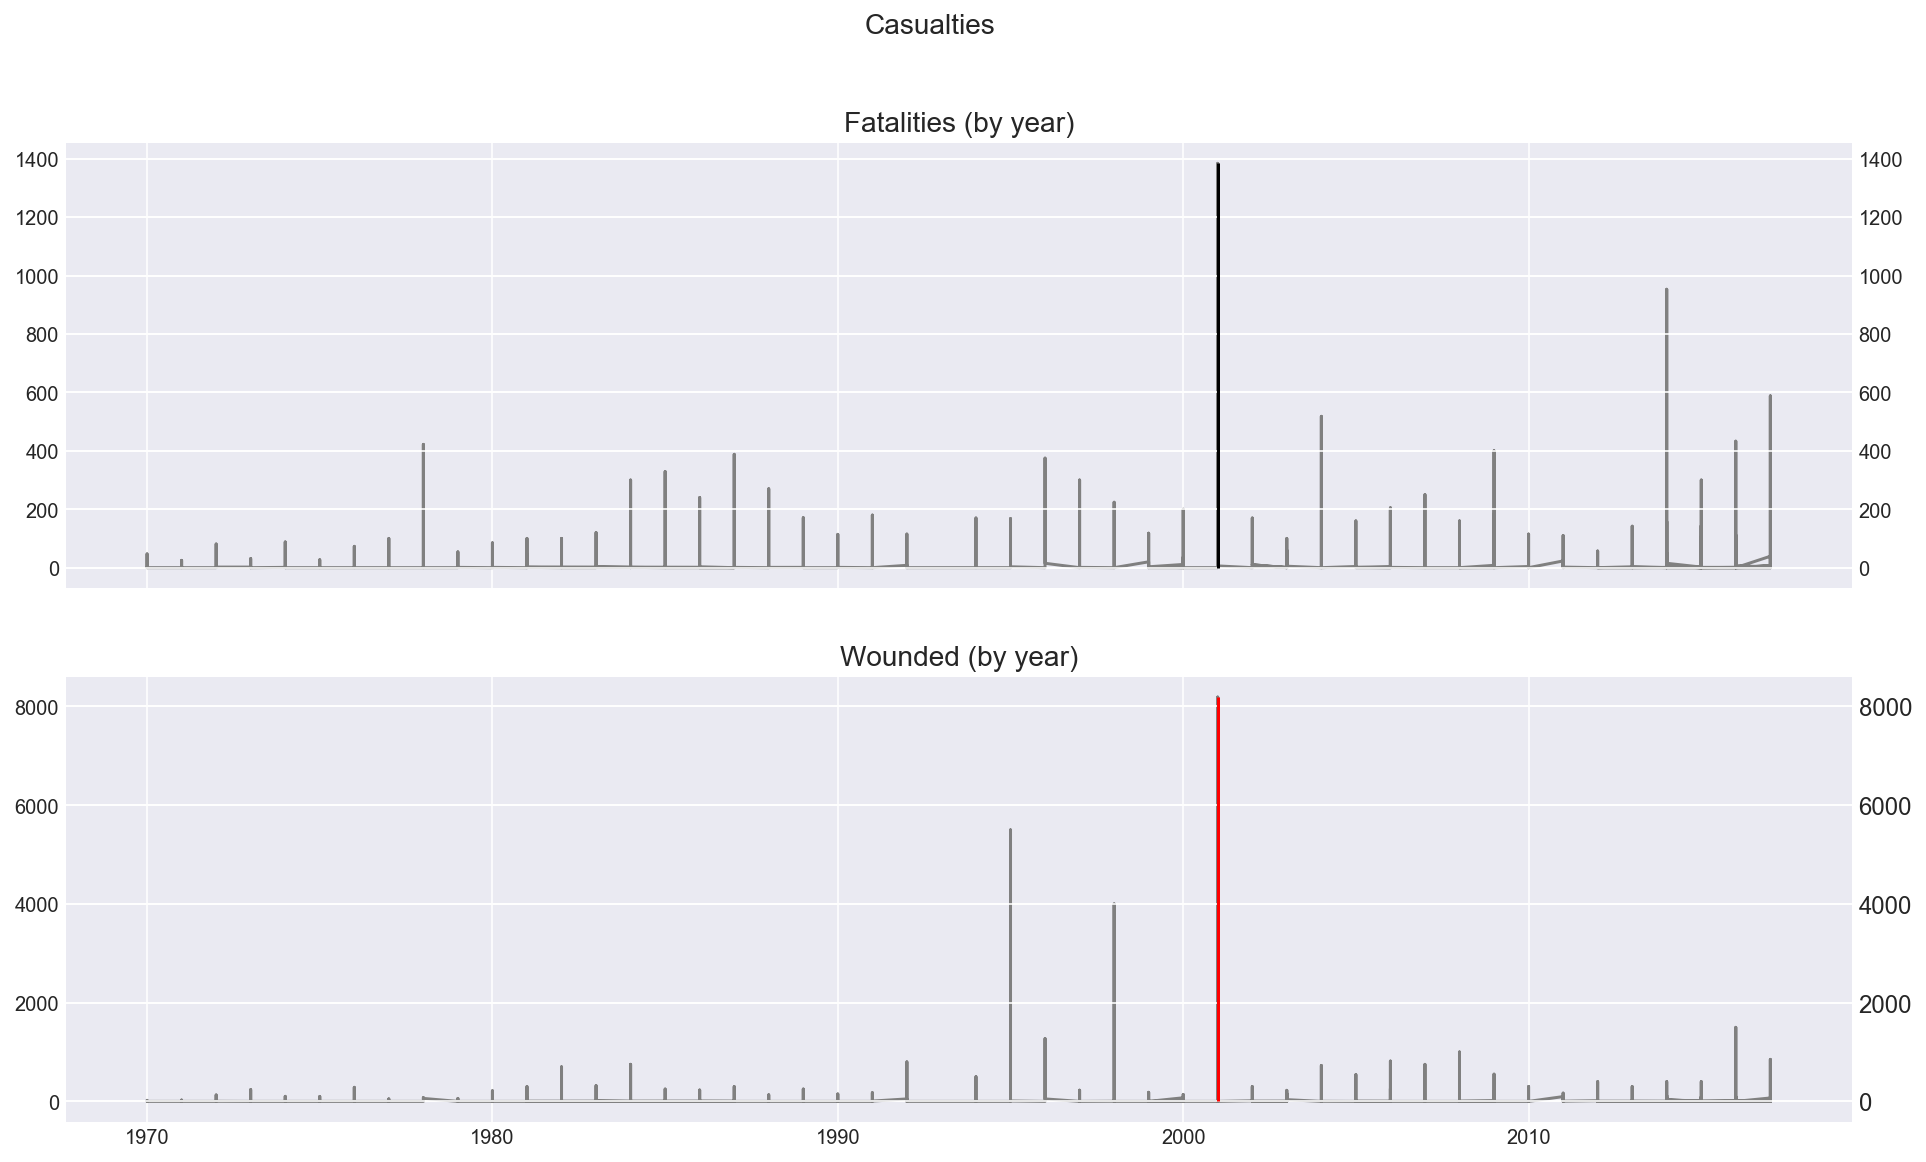

In [36]:
# Lineplot of the nkill and nwound 1970 to 2017
# Set figuresize
fig, (ax1, ax2)  = plt.subplots(nrows=2,ncols=1, figsize=(16,9), sharex=True)
plt.subplots_adjust(hspace=0.2)
plt.suptitle('Casualties', size=14)

#nkill
ax1.plot(df3['iyear'],df3['nkill'], color='gray', label='nkill')
ax1.set_title('Fatalities (by year)', size=14)
ax3 = ax1.twinx()
ax3.vlines(x=2001,ymin=0,ymax=1384,color='black')

#nwound
ax2.plot(df3['iyear'],df3['nwound'], color='gray', label='nwound')
ax2.set_title('Wounded (by year)', size=14);
ax4 = ax2.twinx()
ax4.vlines(x=2001,ymin=0,ymax=8191,color='red')

# Customization
plt.xlabel('year', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

- Though highest number incidences are accorded to years 2014 and 2015, 2001 is the deadliest year, with highest number of fatalities and wounded. What group could be responsible for the spike and what is their mode of attack?

In [37]:
# Investigate incident with highest fatalities
df3.loc[df3['nkill']==1384]

eventid  iyear  imonth  iday        country         region  \
73126  200109110004   2001       9    11  United States  North America   

             lat        lon  crit1  crit2  crit3  success  suicide atkmode  \
73126  40.697132 -73.931351      1      1      1        1        1  hijack   

                    targtype        targnat     gname   motive  indiv  \
73126  citizens and property  united states  al-qaida  unknown      0   

      weaptype  nkill  nwound  property  
73126  vehicle   1384    8190         1

- The 9-11 incidents by AQ accounted for the spike in number of fatalities and wounded reported for year 2001.
- There is a difference in trend in fatalities and wounded (besides 2011) for the years in dataset. Examine the top 3 incidents with highest fatalities and wounded respectively.

In [38]:
# Top 3 deadliest years and corresponding incidents
display(df3['nkill'].sort_values(ascending=False)[:3])
df3.loc[(df3['nkill']>=953) & (df3['nkill']<=1384)]

73126     1384
73127     1383
136283     953
Name: nkill, dtype: int32

eventid  iyear  imonth  iday        country  \
73126   200109110004   2001       9    11  United States   
73127   200109110005   2001       9    11  United States   
136283  201408090071   2014       8     3           Iraq   

                            region        lat        lon  crit1  crit2  crit3  \
73126                North America  40.697132 -73.931351      1      1      1   
73127                North America  40.697132 -73.931351      1      1      1   
136283  Middle East & North Africa  36.319386  41.861473      1      1      1   

        success  suicide         atkmode               targtype  \
73126         1        1          hijack  citizens and property   
73127         1        1          hijack  citizens and property   
136283        1        0  hostage kidnap  citizens and property   

              targnat                                        gname  \
73126   united states                                     al-qaida   
73127   united states                                     al-qaida   
136283           iraq  islamic state of iraq and the levant (isil)   

                                                   motive  indiv weaptype  \
73126                                             unknown      0  vehicle   
73127                                             unknown      0  vehicle   
136283  the specific motive is unknown; however, sourc...      0  unknown   

        nkill  nwound  property  
73126    1384    8190         1  
73127    1383    8191         1  
136283    953       0         1

- The Sep 11 incident is recorded as two separate incidents by AQ in the database.
- In the case of ISIL, the number of fatalities attributed largely to their kidnapping and hard stance on ransom demands.

In [39]:
# Other incidences that AQ carried out in 2001
df3.loc[(df3['iyear']==2001) & (df3['gname']=='al-qaida')]

eventid  iyear  imonth  iday        country          region  \
73126  200109110004   2001       9    11  United States   North America   
73127  200109110005   2001       9    11  United States   North America   
73128  200109110006   2001       9    11  United States   North America   
73129  200109110007   2001       9    11  United States   North America   
73526  200112220002   2001      12    22         France  Western Europe   

             lat        lon  crit1  crit2  crit3  success  suicide  atkmode  \
73126  40.697132 -73.931351      1      1      1        1        1   hijack   
73127  40.697132 -73.931351      1      1      1        1        1   hijack   
73128  38.878742 -77.100006      1      1      1        1        1   hijack   
73129  40.018464 -78.907197      1      1      1        1        1   hijack   
73526  48.856644   2.342330      1      1      1        0        1  bombing   

                    targtype        targnat     gname   motive  indiv  \
73126  citizens and property  united states  al-qaida  unknown      0   
73127  citizens and property  united states  al-qaida  unknown      0   
73128                general  united states  al-qaida  unknown      0   
73129  citizens and property  united states  al-qaida  unknown      0   
73526           airtransport  united states  al-qaida  unknown      0   

         weaptype  nkill  nwound  property  
73126     vehicle   1384    8190         1  
73127     vehicle   1383    8191         1  
73128     vehicle    190     106         1  
73129     vehicle     44       6         1  
73526  explosives      0       1         0

- The Sep 11 incidents is a coordinated act that consists of four hijacked aircrafts. From literature research, https://en.wikipedia.org/wiki/September_11_attacks, two impacted the twin towers, one impacted the pentagon, and one impacted a field (did not reach intended attack site).
- The shoe bomb attempt by AQ in France, 2001 was foiled. It resulted in tightened security screening measures in airports. https://en.wikipedia.org/wiki/2001_shoe_bomb_attempt
- It appears 2001 may be the year terror group tactics shifted focus to targetting of general populance (U.S. and allies).

In [40]:
# Top 3 years with highest wounded and corresponding incident
# Number wounded
display(df3['nwound'].sort_values(ascending=False)[:3])
# Incident details
df3.loc[(df3['nwound']>=5500) & (df3['nwound']<=8191)]

73127    8191
73126    8190
58841    5500
Name: nwound, dtype: int32

eventid  iyear  imonth  iday        country         region  \
58841  199503200014   1995       3    20          Japan      East Asia   
73126  200109110004   2001       9    11  United States  North America   
73127  200109110005   2001       9    11  United States  North America   

             lat         lon  crit1  crit2  crit3  success  suicide  \
58841  35.689125  139.747742      1      1      1        1        0   
73126  40.697132  -73.931351      1      1      1        1        1   
73127  40.697132  -73.931351      1      1      1        1        1   

               atkmode               targtype        targnat           gname  \
58841  unarmed assault         transportation          japan  aum shinri kyo   
73126           hijack  citizens and property  united states        al-qaida   
73127           hijack  citizens and property  united states        al-qaida   

        motive  indiv  weaptype  nkill  nwound  property  
58841  unknown      0  chemical     13    5500         1  
73126  unknown      0   vehicle   1384    8190         1  
73127  unknown      0   vehicle   1383    8191         1

- The incident besides Sep 11 with highest injuries is carried out by the Aum Shinrikyo cult of Japan on its citizens using the metro.

### Incidents by the Groups

In [41]:
# Number of terror groups in dataset
print(f"Number of terror groups:{len(df3['gname'].value_counts())}")

Number of terror groups:3062


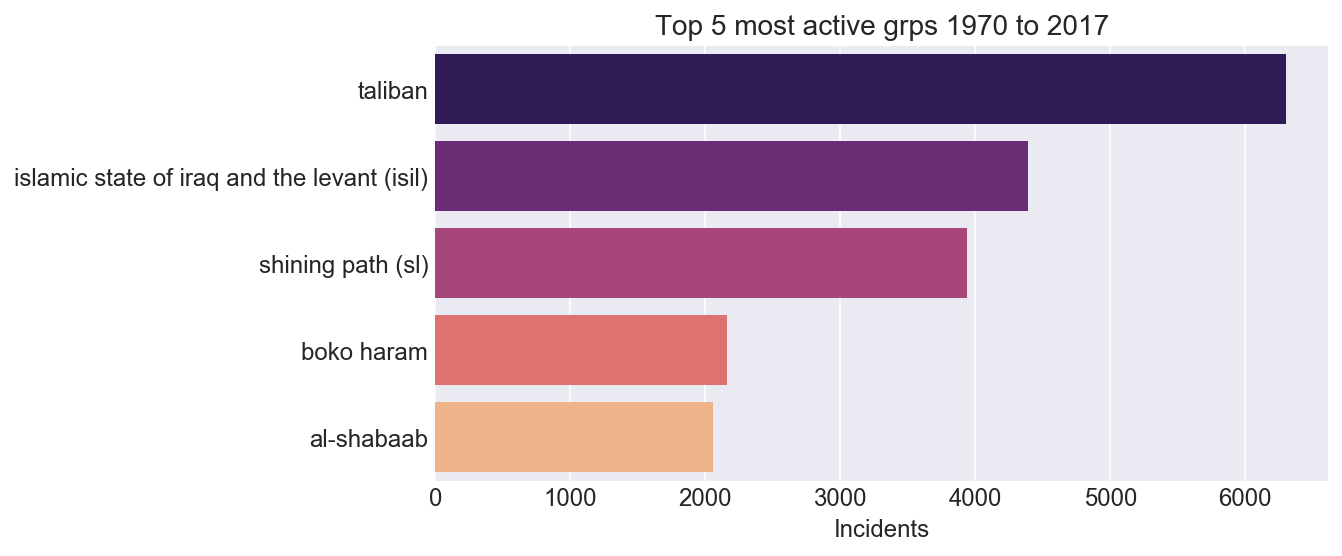

In [42]:
# Top 5 most active groups
# Skip index 0; attacks which unable to be attributed to particular group
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(df3['gname'].value_counts()[1:6].values,df3['gname'].value_counts()[1:6].index,palette=('magma'));
# customization
plt.xlabel('Incidents',fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Top 5 most active grps 1970 to 2017',size=14)
plt.show();

In [43]:
# Names of top 5 most active group
# Index 0 referred 'Unknown' group; pepretrator of incident unknown.
df3['gname'].value_counts()[1:6].index

Index(['taliban', 'islamic state of iraq and the levant (isil)',
       'shining path (sl)', 'boko haram', 'al-shabaab'],
      dtype='object')

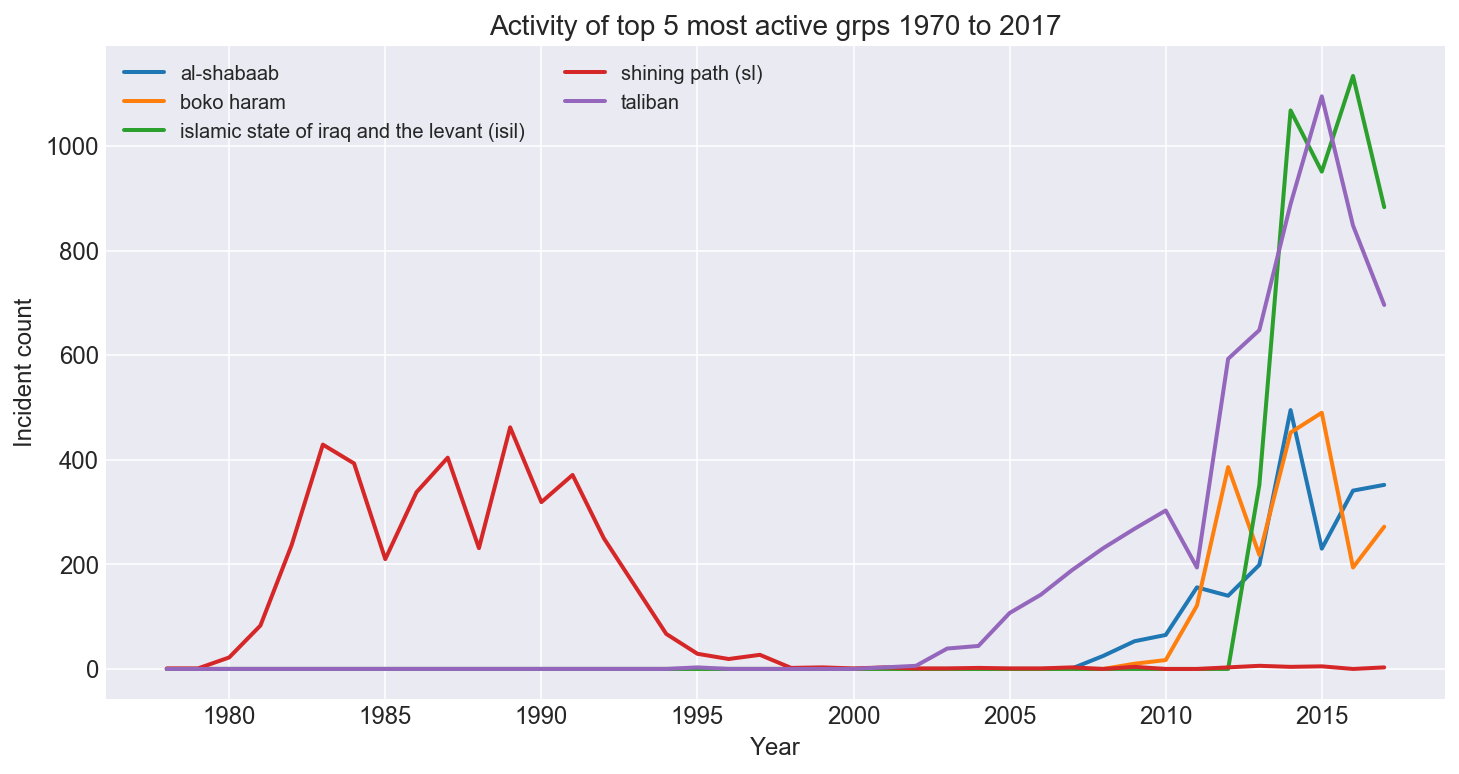

In [44]:
# Activity of top 5 most active group over the years
top_5=df3[df3['gname'].isin(df3['gname'].value_counts()[1:6].index)]
# Figure size
fig, ax = plt.subplots(figsize = (12,6))
# Compute frequency table of the factors using pd.crosstab, then plot it
plt.plot(pd.crosstab(top_5.iyear,top_5.gname),linewidth=2)
# Customization
plt.xlabel('Year',fontsize=12)
plt.xticks(size=12)
plt.ylabel('Incident count',fontsize=12)
plt.yticks(size=12)
plt.title('Activity of top 5 most active grps 1970 to 2017',size=14)

# Arrange the gname by alphabetical order for legend
plt.legend(['al-shabaab', 'boko haram','islamic state of iraq and the levant (isil)',\
            'shining path (sl)','taliban'],ncol=2,loc='upper left');

- Apart from the rest, sl activity declined following 1995.
- The rest of the groups became active following 2000, with isil and taliban being most active. Notably, activities of these groups mostly declined after 2015 (al-shabaab being the exception). 
- from its emergence, isil has the steepest gradient in incidents over time.

In [45]:
# create a column ncasualty = nkill + nwound
feat1 = ['iyear','gname','weaptype','atkmode','targtype','nkill','nwound']
df4 = df3[feat1].copy()
df4['ncasualty'] = df4['nkill']+df4['nwound']
df5 = df4.groupby(['gname'])[['ncasualty']].sum().reset_index()
# Skip index 0; attacks which unable to be attributed to particular group
# Sort and return top 5 groups with highest ncasualty
df6 = df5.sort_values(by='ncasualty',ascending=False)[1:6].copy()

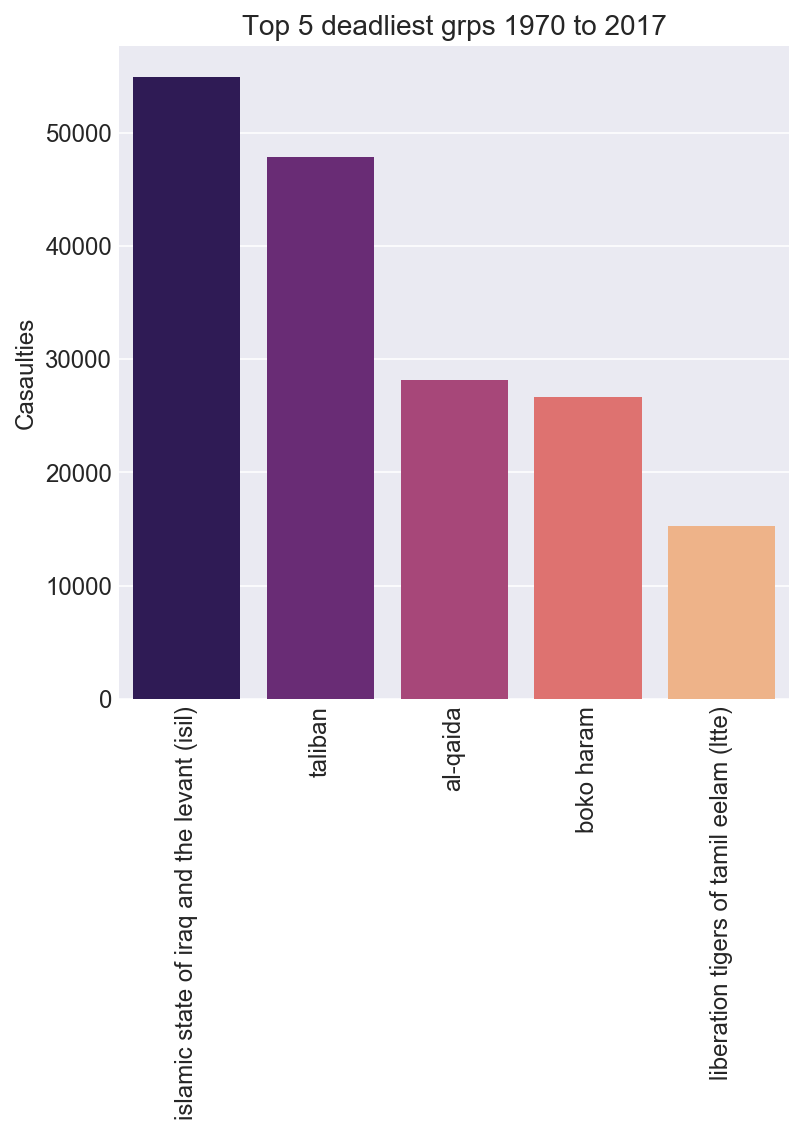

In [46]:
# Top 5 most deadly grps
fig, ax = plt.subplots(figsize = (6,6))
sns.barplot(df6['gname'],df6['ncasualty'],palette='magma');
# customization
plt.xlabel("")
plt.xticks(rotation=90, size=12)
plt.ylabel('Casaulties',size=12)
plt.yticks(size=12)
plt.title('Top 5 deadliest grps 1970 to 2017',size=14);

In [47]:
# Number of incidents carried out by ltte
len(df3.loc[df3['gname']=='liberation tigers of tamil eelam (ltte)'])

1052

- Compared to prior top 5 most active groups over the years, the ltte came in the last (1052 incidents in total (1970 to 2017)), yet it accounted for one of the highest casualties numbers (3rd highest) among these groups.

### Incidents by Modulus Operandi (attack modes)

Is there any difference in the tactics utilised among the top 5 active groups? For example, how does the methods of isil compare with that of the A-Q (notorious with its high profile Sep 11 attacks on the U.S.)?


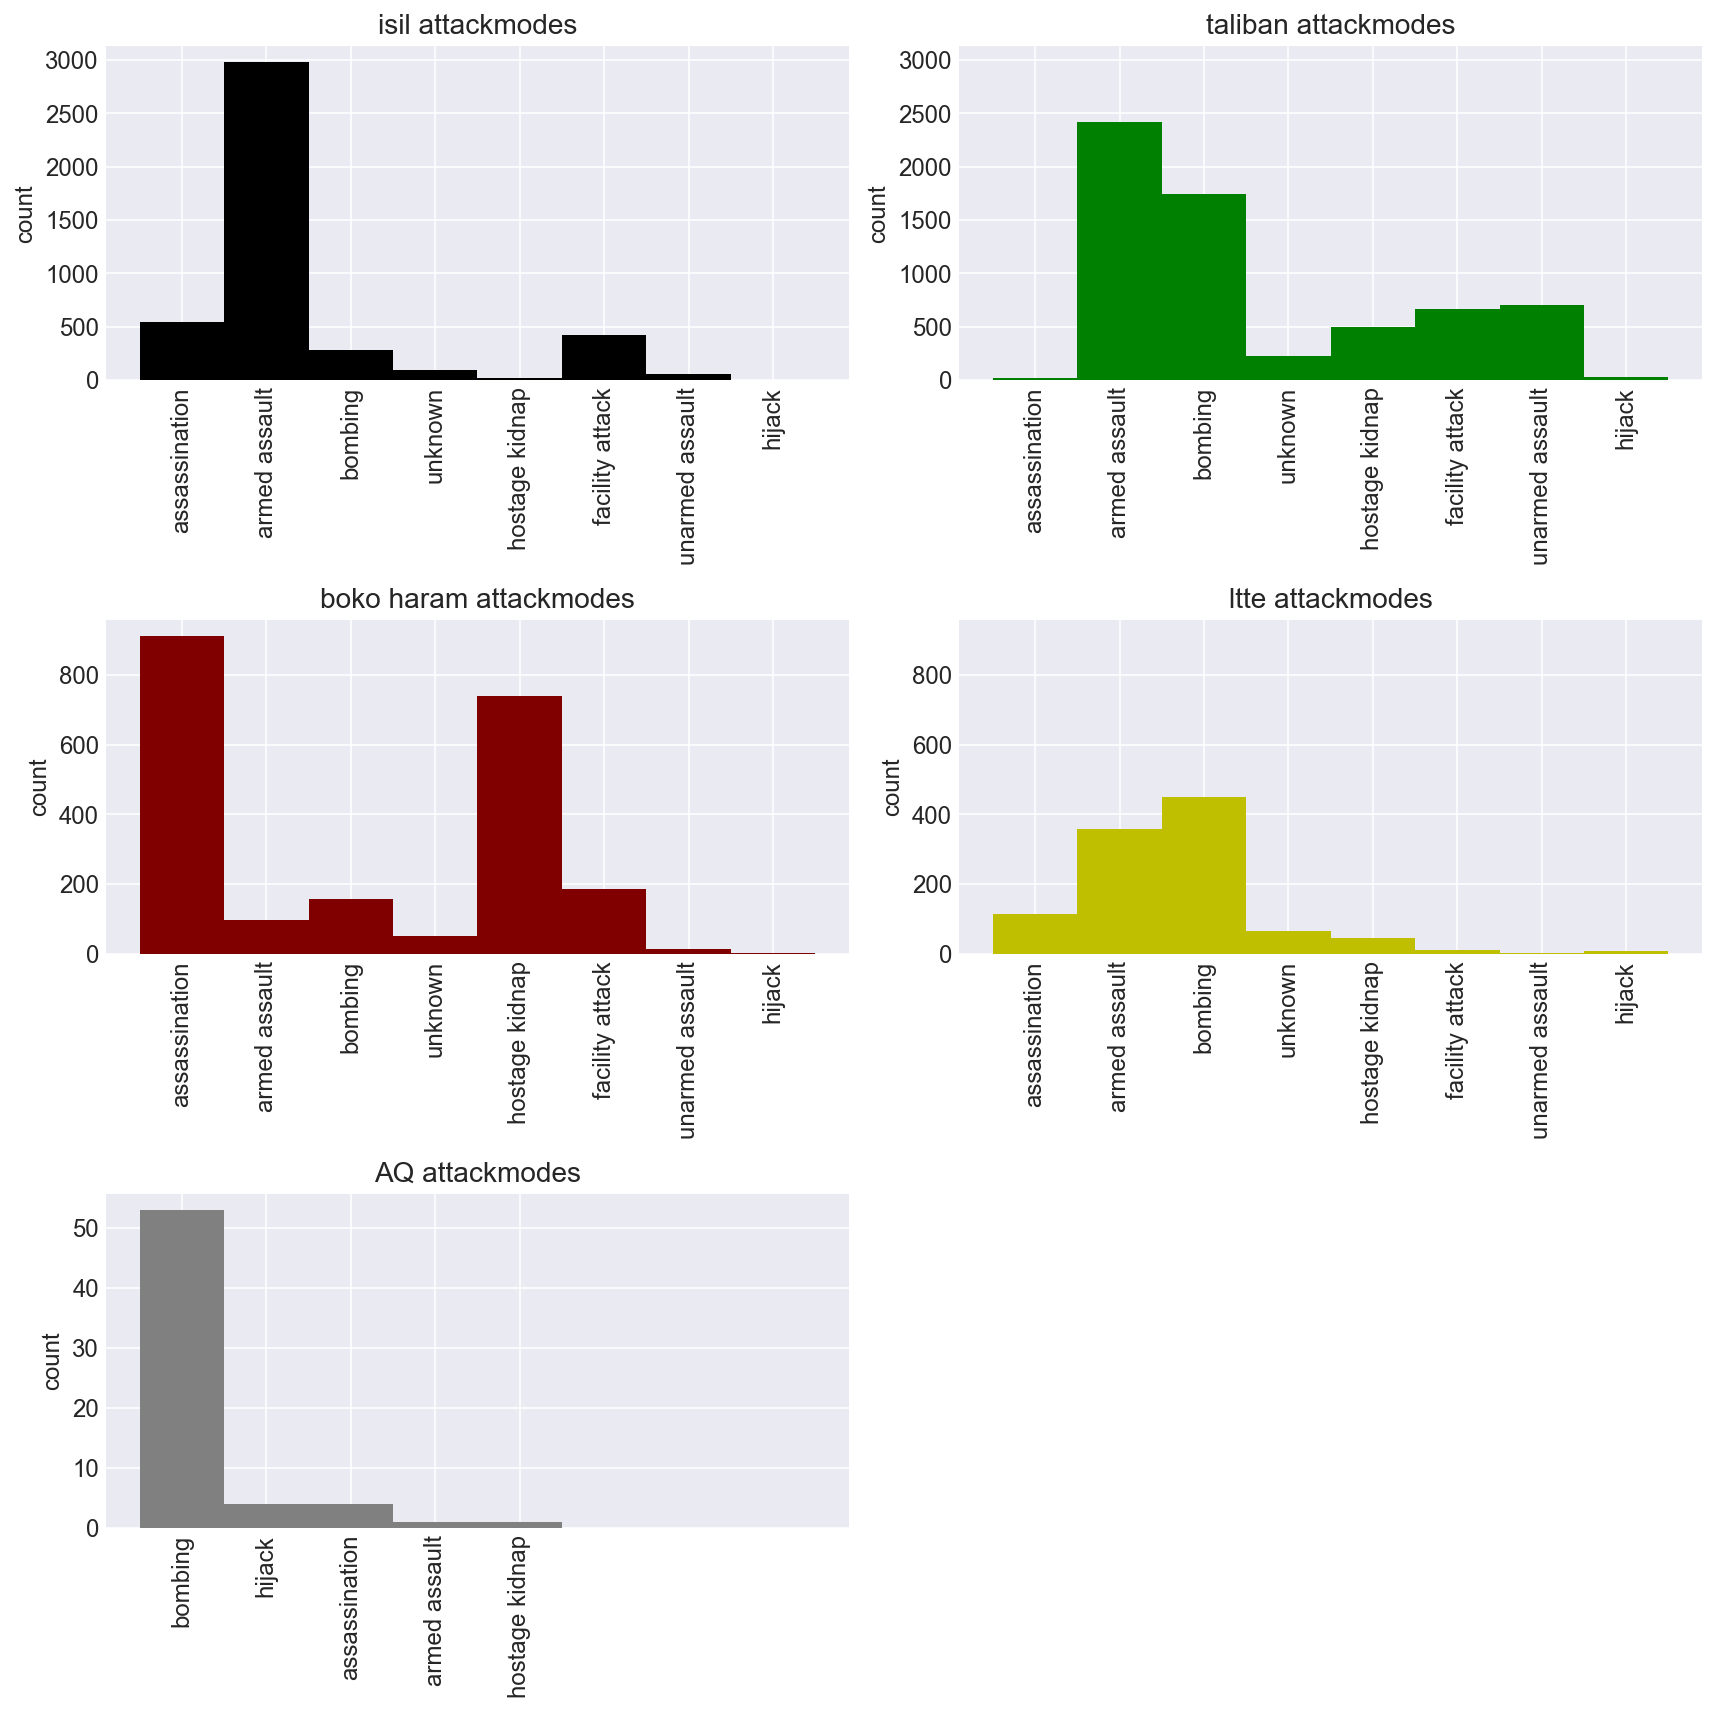

In [48]:
# Subplots for groups
f = plt.figure(figsize=(12,12))

# isil (top left)
ax1 = plt.subplot(3,2,1)
plt.hist(df3.loc[df3['gname'] == 'islamic state of iraq and the levant (isil)']['atkmode'],bins=np.arange(9)-0.5,
         color='black')
plt.title('isil attackmodes',fontsize=14)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('count',fontsize=12);

# taliban (top right)
ax2 = plt.subplot(3,2,2,sharex=ax1,sharey=ax1)
plt.hist(df3.loc[df3['gname'] == 'taliban']['atkmode'],bins=np.arange(9)-0.5,color='g')
plt.title('taliban attackmodes',fontsize=14)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('count',fontsize=12);

# boko harem (middle left)
ax3 = plt.subplot(3,2,3,sharex=ax1)
plt.hist(df3.loc[df3['gname'] == 'boko haram']['atkmode'],bins=np.arange(9)-0.5,color='maroon')
plt.title('boko haram attackmodes',fontsize=14)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('count',fontsize=12)
f.tight_layout();

# ltte (middle right)
ax4 = plt.subplot(3,2,4,sharex=ax1,sharey=ax3)
plt.hist(df3.loc[df3['gname'] == 'liberation tigers of tamil eelam (ltte)']['atkmode'],bins=np.arange(9)-0.5,
        color='y')
plt.title('ltte attackmodes',fontsize=14)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('count',fontsize=12)
f.tight_layout();

# AQ (bottom left)
ax5 = plt.subplot(3,2,5)
plt.hist(df3.loc[df3['gname'] == 'al-qaida']['atkmode'],bins=np.arange(9)-0.5,color='gray')
plt.title('AQ attackmodes',fontsize=14)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('count',fontsize=12)
f.tight_layout();

- from its emergence to decline, isil carried out more incidents than any other groups, favouring bombing.
- AQ conducted the least incidents, but accounted for significant casaulties (ranked 3rd by descending number of casaulties). The high profile Sep 11 attacks likely accounted for the significant numbber of casualties. Compared to other groups, it either did not target facilties, nor conduct unarmed assault (or not incidents attributable nor claied by them).

Given the extreme incident in 2011 carried out by AQ, was there a fundamental shift in tactics to target general populance more actively? Specifically, was there any change in groups' i) modes of attack and ii) targets by the decades? We examine the trends from 2000-2017.

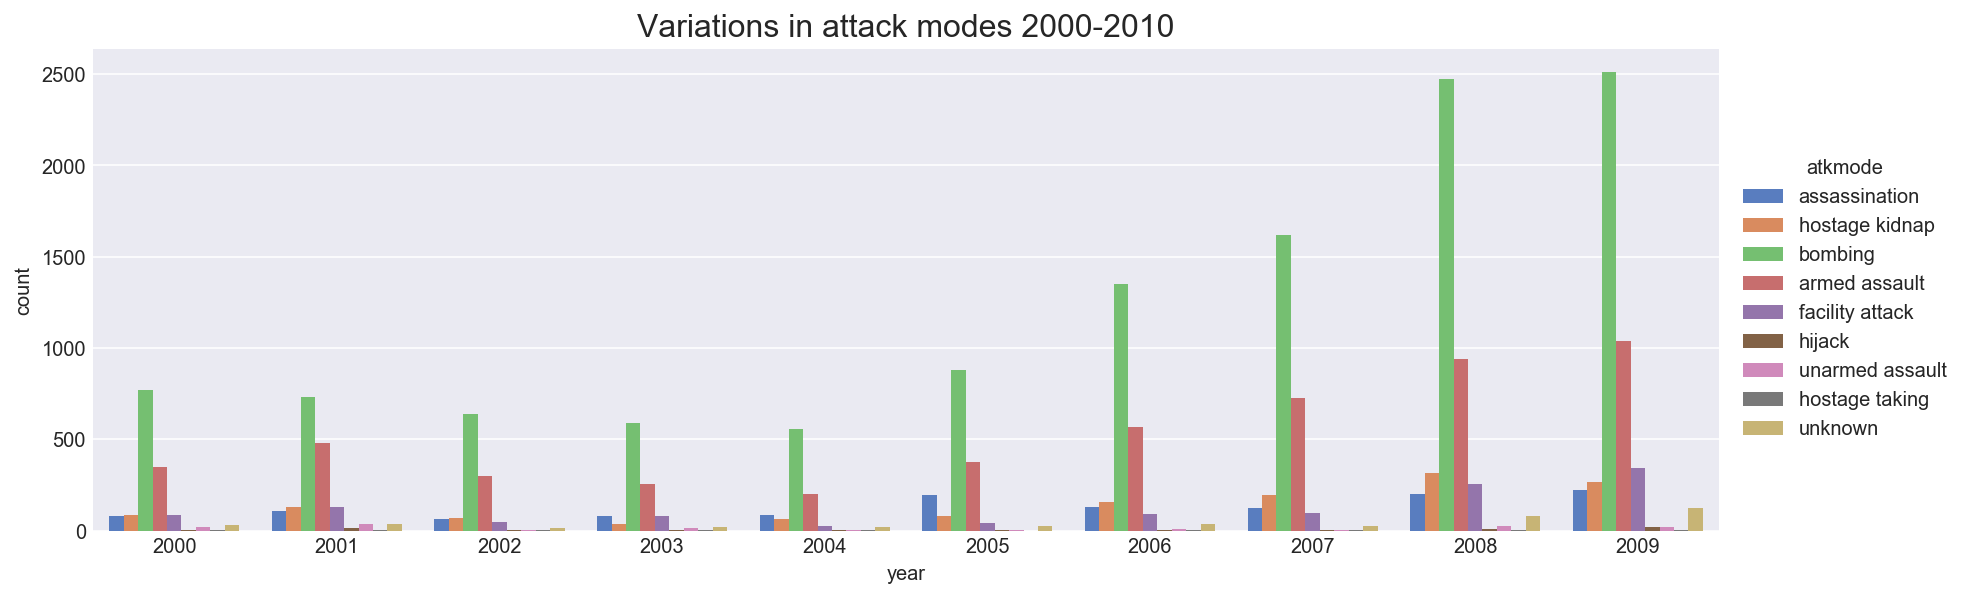

In [49]:
# Distribution of attack modes year 2000-2010
sns.catplot("iyear", data=df3, kind='count', hue='atkmode', order=range(2000, 2010),height=4, aspect=3,palette='muted')
plt.xlabel("year")
plt.title('Variations in attack modes 2000-2010',size=16);

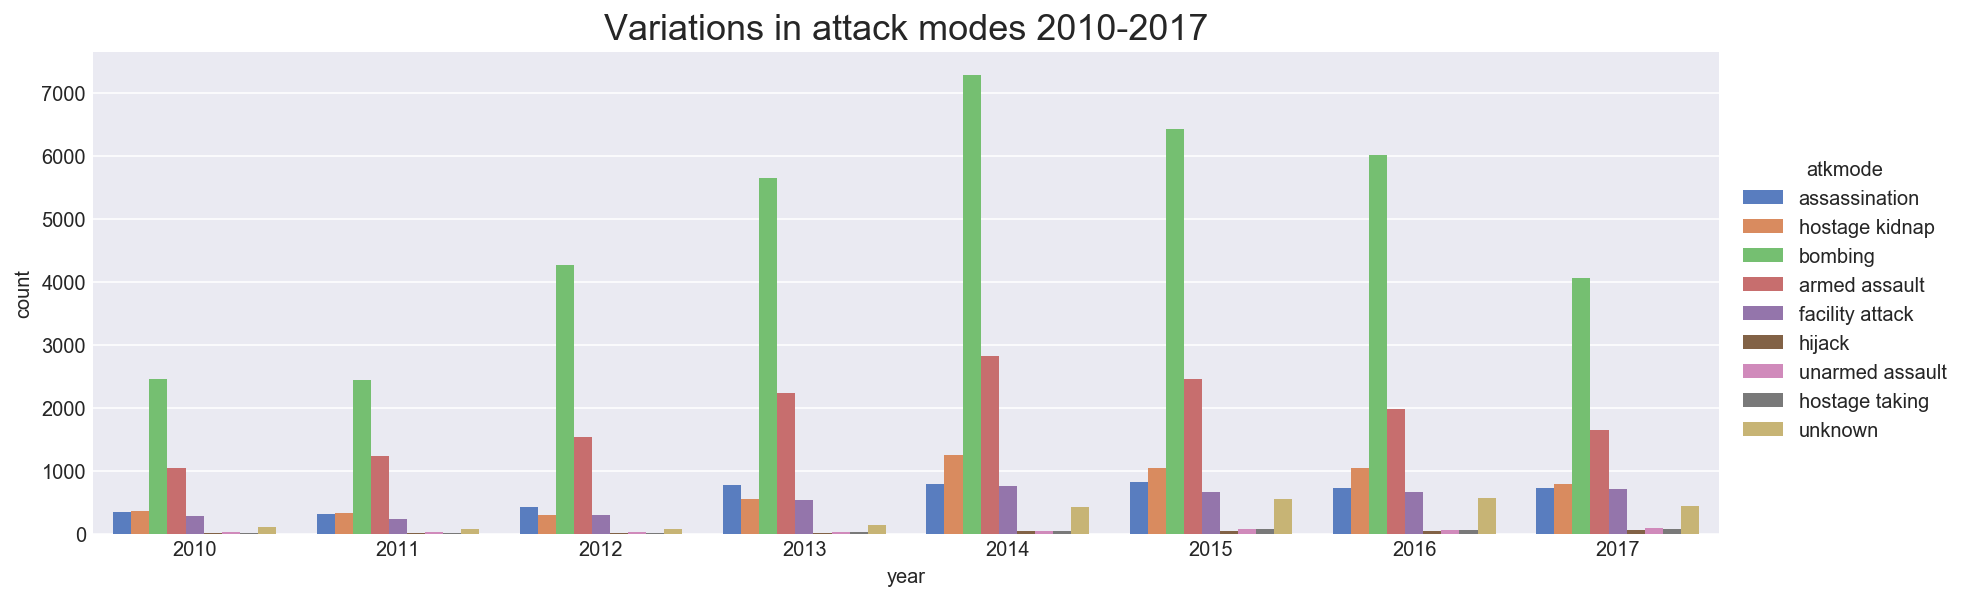

In [50]:
# Distribution of attack modes year 2010-2017
sns.catplot("iyear", data=df3, kind='count', hue='atkmode', order=range(2010, 2018),height=4, aspect=3,palette='muted')
plt.xlabel("year")
plt.title('Variations in attack modes 2010-2017',size=18);

- There does not appear to be a fundamental shift in the general modes of attacks over the years. Notably, the number of incidents increased through the decades while proportion of attack modes remained generally consistent. 
- Increased incidents could be due to rise of extremism in select regions, social-political shifts, increased digital and information connectivity.
- Bombing remains the favoured tactic, followed closely by armed assault and kidnapping in more recent years (i.e. 2000 onwards).

In [51]:
# Dataframe of atkmode groups and ncausalty summed
df7 = df4.groupby(['atkmode'])[['ncasualty']].sum().reset_index()
# Dataframe of atkmode entries and respective casualties
df8 = df4.groupby(['atkmode']).size().to_frame(name = 'inci_count').reset_index()
df7['avg_ncasualty'] = df7['ncasualty']/df8['inci_count']

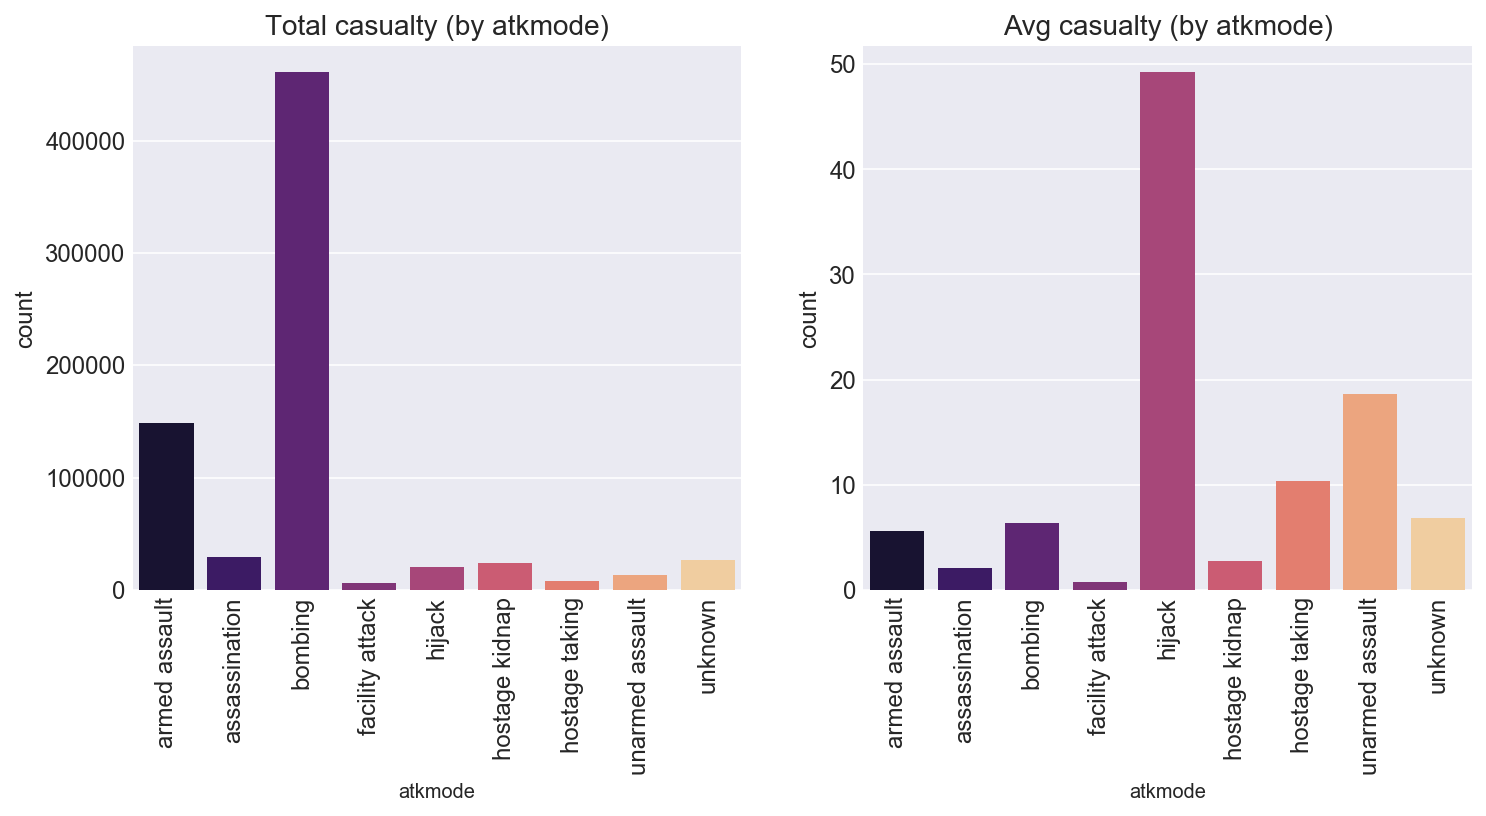

In [52]:
# Subplots for isil (left), taliban (right)
f = plt.figure(figsize=(12,5))

# 1row,2col,1stplot
ax1 = plt.subplot(1,2,1)
sns.barplot(df7['atkmode'],df7['ncasualty'],palette='magma')
plt.title('Total casualty (by atkmode)',fontsize=14)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('count',fontsize=12);

# 1row,2col,2ndplot
ax2 = plt.subplot(1,2,2,sharex=ax1)
sns.barplot(df7['atkmode'],df7['avg_ncasualty'],palette='magma')
plt.title('Avg casualty (by atkmode)',fontsize=14)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('count',fontsize=12);

- By sheer number of bombing incidences, bombing has highest absolute total casualties. However, hijacking has highest average casualty numbers (almost 5 times as much as bombing).
- Unarmed assault consists of attacks utilizing chemical, incendiary, vehicle as weapon, in addition to melee-type weapons. This would explain the higher average casualties compared to armed assault (large majority being firearms).

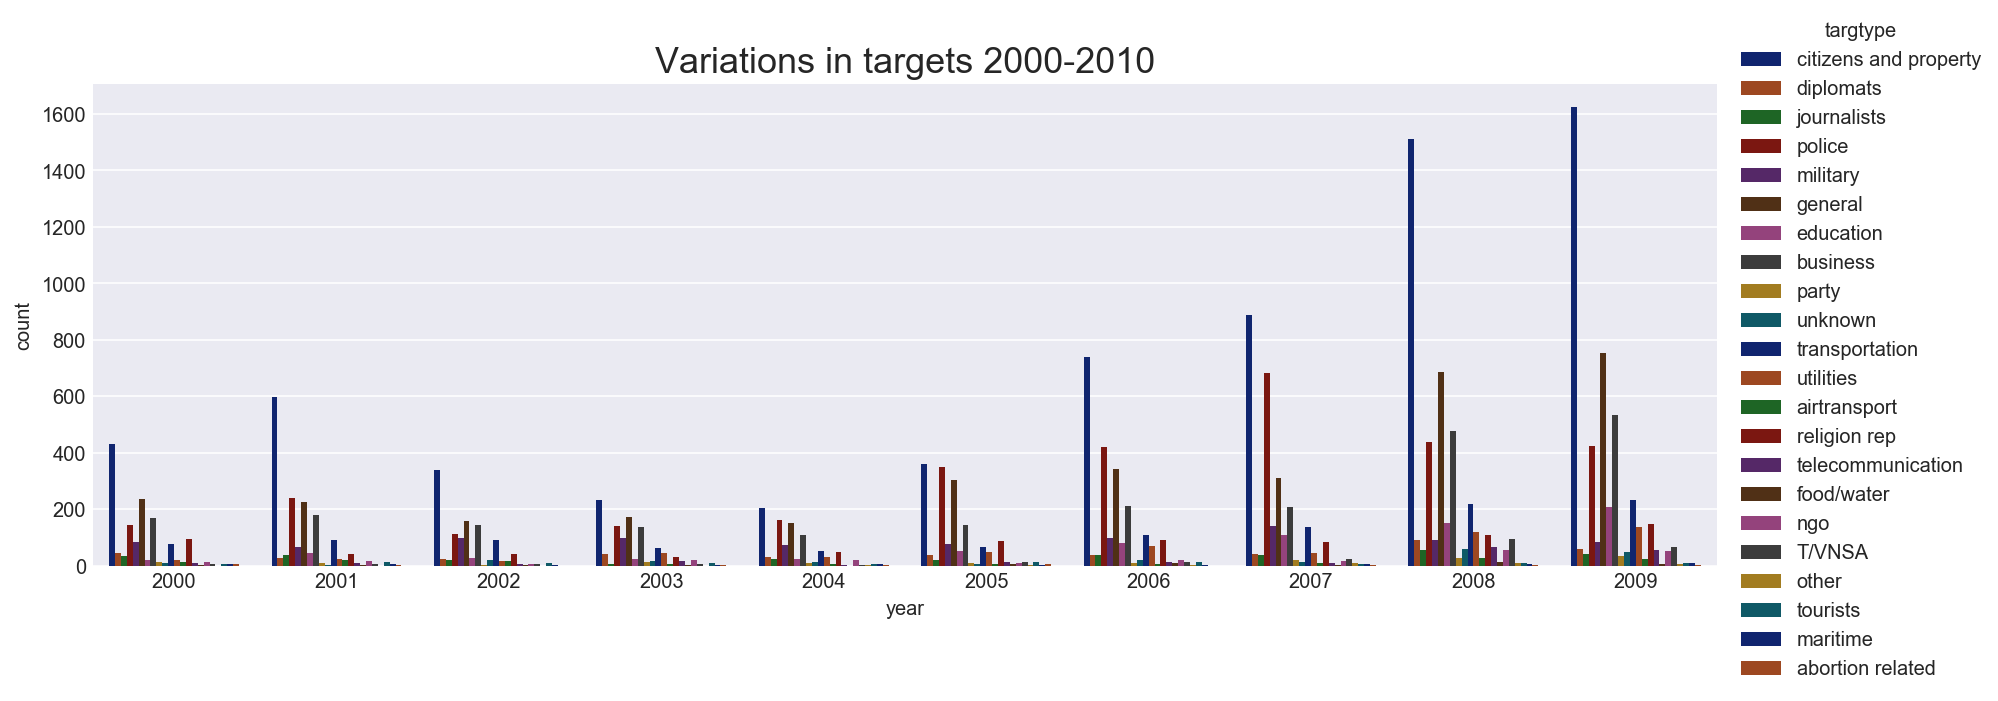

In [53]:
# Distribution of attack modes year 2000-2010
sns.catplot("iyear", data=df3, kind='count', hue='targtype', order=range(2000, 2010),height=4, aspect=3,palette='dark')
plt.xlabel("year")
plt.title('Variations in targets 2000-2010',size=18);

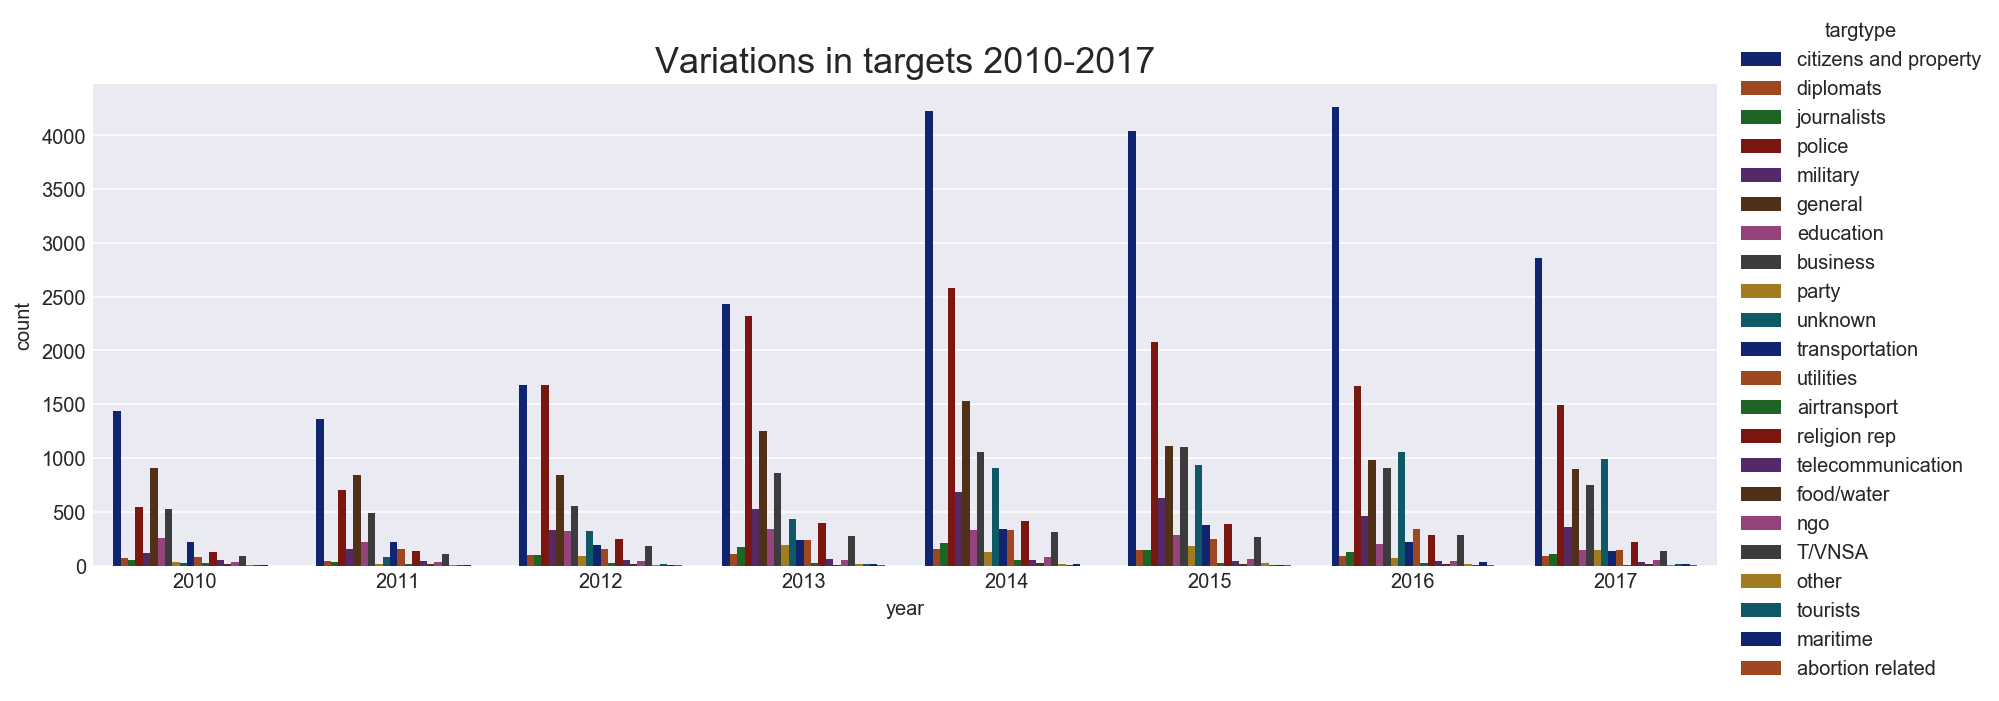

In [54]:
# Distribution of attack modes year 2010-2017
sns.catplot("iyear", data=df3, kind='count', hue='targtype', order=range(2010, 2018),height=4, aspect=3,palette='dark')
plt.xlabel("year")
plt.title('Variations in targets 2010-2017',size=18);

- Regardless of the years, the general populance and property remains the top target for terror groups.
- Notably, between 2012 to 2014, the police came under increased terror attacks. 

In [55]:
df_suce = df3.groupby(['country','atkmode','success']).size().to_frame(name = 'sf_count').reset_index()

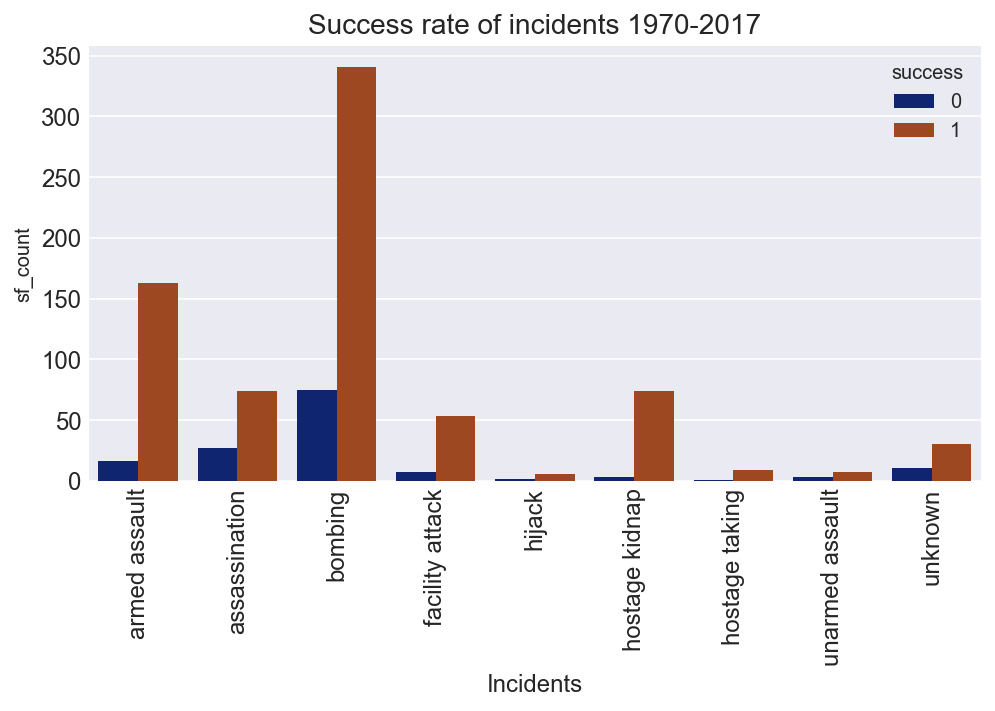

In [56]:
# Profile of most successful attack modes
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot("atkmode", "sf_count", hue='success', data=df_suce, ci=None, palette='dark')

# customization
plt.xlabel('Incidents',fontsize=12)
plt.xticks(rotation=90,size=12)
plt.yticks(size=12)
plt.title('Success rate of incidents 1970-2017',size=14)
plt.show();

- In general, all attackmodes have more successes than failures. By proportion, since bombing has highest proportion, it also has the highest number of successes.
- The following countries and highest count of successful incident are displayed below. 

In [57]:
# Countries with most number of successful incidents, by attack modes.
df_suce.sort_values('sf_count',ascending=False)[:5]

country        atkmode  success  sf_count
640          Iraq        bombing        1     14859
1055     Pakistan        bombing        1      5587
5     Afghanistan        bombing        1      4713
596         India        bombing        1      3205
1051     Pakistan  armed assault        1      2764

Before ending this section, we examine the means utilized by terror groups, specifically radiological (nuclear capabilities). A terrorist attack using nuclear or radiological materials is a low-probability event, but if executed, would lead to unprecedented socio-economic, material, and psychological disruption and damage. Which were the groups that utilized such means?

In [58]:
# Review the list of weapon types
df3['weaptype'].unique()

array(['unknown', 'explosives', 'firearms', 'incendiary', 'chemical',
       'melee', 'sabotage equipment', 'vehicle', 'fake weapons',
       'radiological', 'other', 'biological'], dtype=object)

In [59]:
df_rad = df3.loc[df3['weaptype']=='radiological'].copy()
df_rad = df_rad.groupby(['targnat','gname','iyear'])['crit1'].sum().reset_index()
df_rad

targnat                                              gname  iyear  crit1
0  austria                                 justice guerrillas   1974      1
1   france  ecology and antinuclear revolutionary party (c...   1979      1
2    japan                                            unknown   2000     10

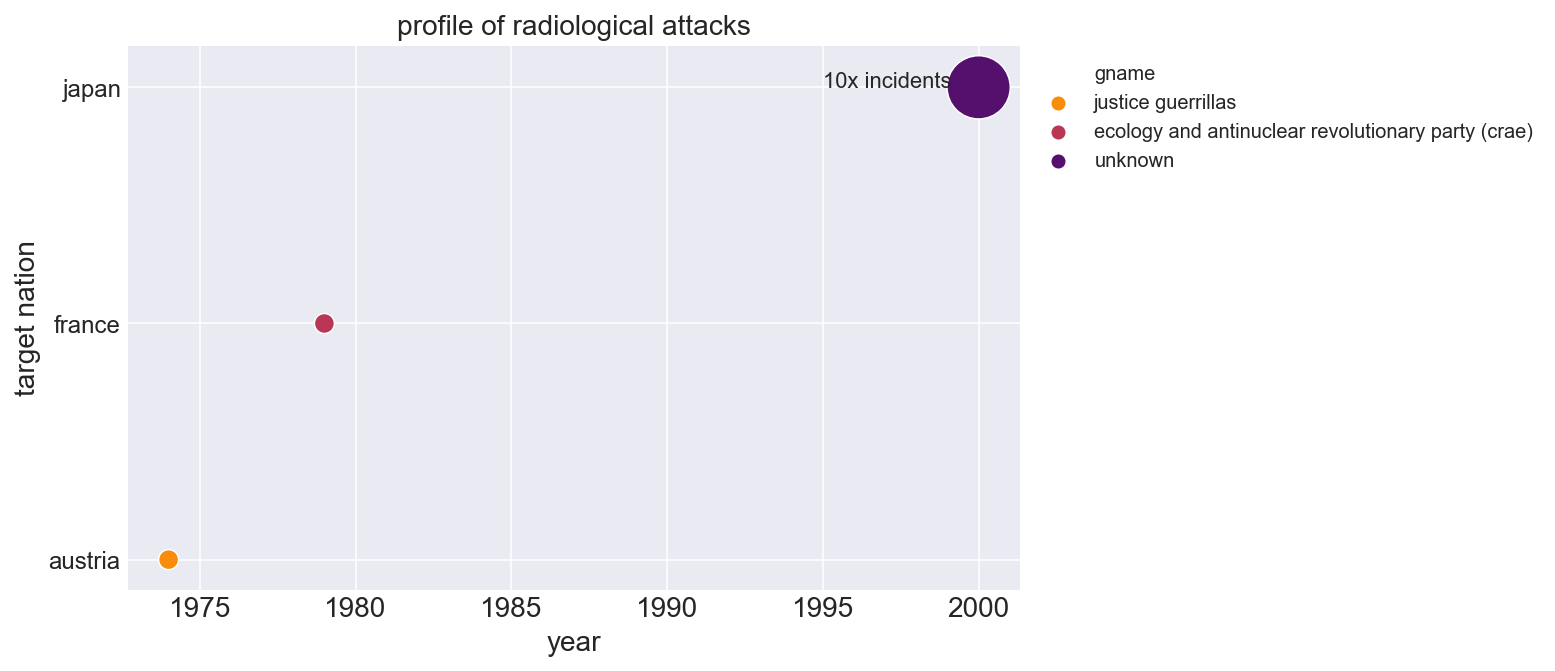

In [60]:
# Plot size
f = plt.figure(figsize=(8,5))
# Plot
# Use crit1 as proxy for count of instance
ax = sns.scatterplot(x="iyear", y="targnat", hue="gname",palette='inferno_r',data=df_rad,s=df_rad['crit1']*100)

# Add labels to the plot
ax.annotate('10x incidents', xy=(1995, 'japan'), xytext=(1995, 'japan'),size=11)
# Customize
plt.title('profile of radiological attacks',fontsize=14)
plt.xlabel('year',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('target nation',fontsize=14)
plt.yticks(fontsize=12)
ax.legend(bbox_to_anchor=(1, 1));

Observations:
- At this point, we weren't able to uncover related literature regarding nuclear terrorism in Japan year 2000. This is further supported by the observation that the true peperator remains unidentified. We could further explore this in a separate project endeavour.

### Terrorism by Geography

In [61]:
print(f"Regions in dataset: {df3['region'].unique()}")
print()
df_reg=df3.copy()
df_reg = df_reg.groupby(['region','lon','lat']).size().to_frame(name = 'inci_count').reset_index()
# Top 10 regions with most incidents
df_reg.region.value_counts()[:10]

Regions in dataset: ['Central America & Caribbean' 'North America' 'Southeast Asia'
 'Western Europe' 'South America' 'Eastern Europe'
 'Middle East & North Africa' 'East Asia' 'Australasia & Oceania'
 'South Asia' 'Sub-Saharan Africa' 'Central Asia']



South Asia                     13908
Middle East & North Africa      6843
Sub-Saharan Africa              5468
Southeast Asia                  4662
South America                   2812
Western Europe                  2222
Eastern Europe                  1254
North America                    947
Central America & Caribbean      897
East Asia                        177
Name: region, dtype: int64

Observations:
- Terrorism incidences are mostly centered in these regions: South Asia, the Middle East & North Africa, Sub-Saharan Africa and SouthEast Asia.
- This is more evident when the cumulative number of incidents (1970-2017) are overlayed on the the world map (See below).

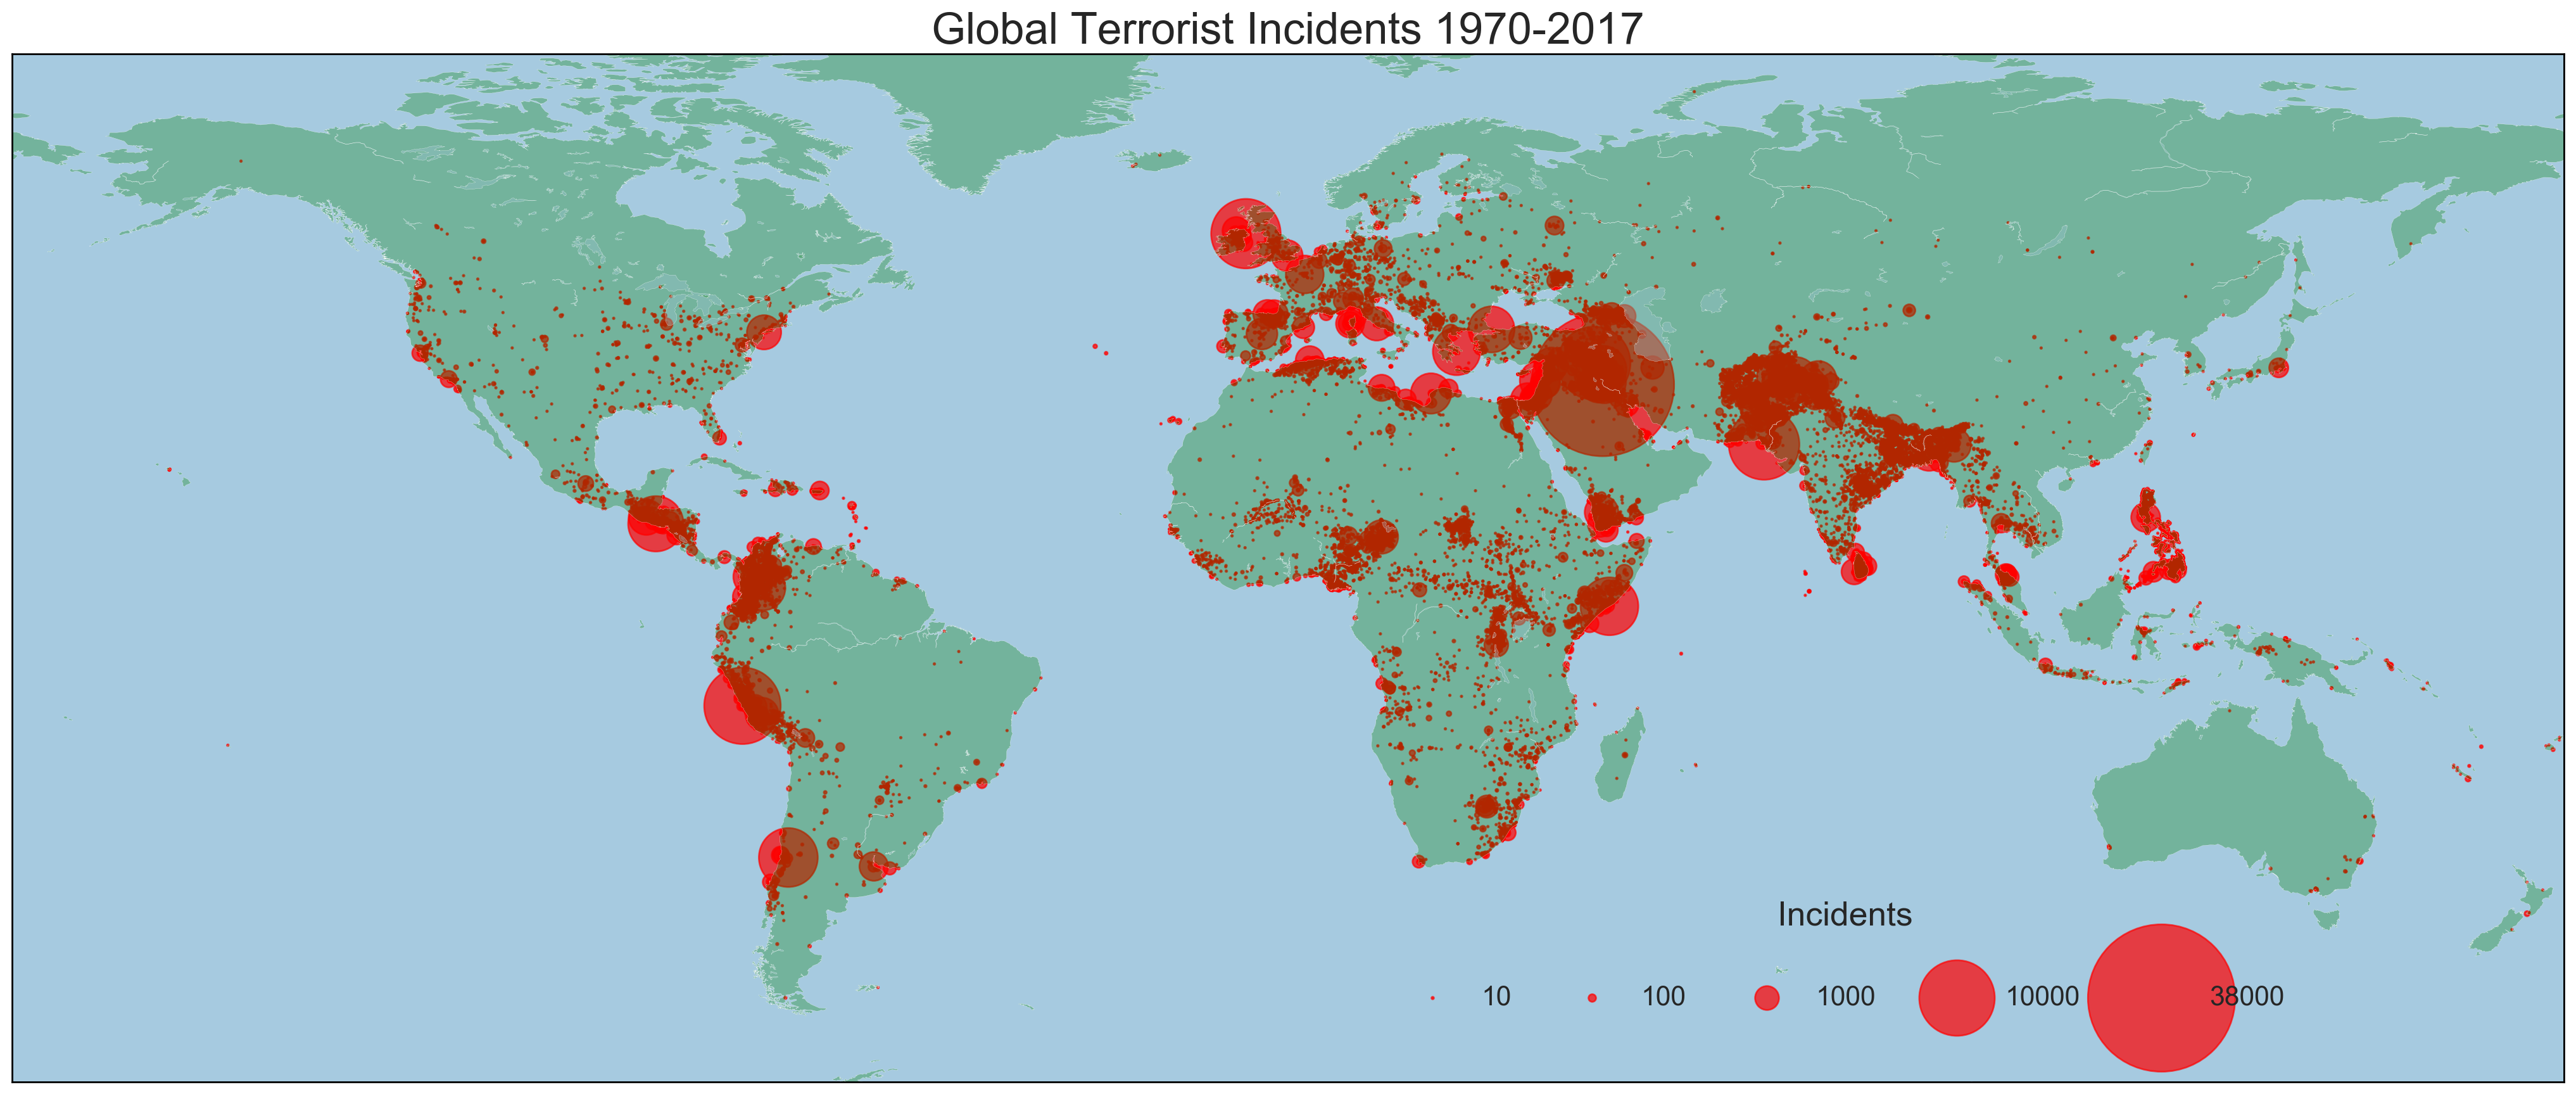

In [62]:
# Starter code from https://python-graph-gallery.com/315-a-world-map-of-surf-tweets/
# and https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
# More reference:https://basemaptutorial.readthedocs.io/en/latest/backgrounds.html
# Set the dimension of the figure
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

# Make the background map
m=Basemap(projection='cyl',llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80,resolution='l')
m.drawmapboundary(fill_color='#A6CAE0', linewidth=1)
m.fillcontinents(color='green', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
# Too busy a map if used; preserved for learning
#m.bluemarble()

# Add a point per position
m.scatter(df_reg['lon'], df_reg['lat'],s=df_reg.inci_count, alpha=0.7, c='r')
# Title
plt.title("Global Terrorist Incidents 1970-2017", fontsize=26)
# Legend
for a in [10,100,1000,10000,38000]:
    plt.scatter([], [], c='r', alpha=0.7, s=a/5, label=str(a))
plt.legend(scatterpoints=1, frameon=False, labelspacing=2, loc='upper right',bbox_to_anchor=(0.9,0.2,0,0),\
           title ='Incidents',ncol=5, title_fontsize=20, fontsize=16);

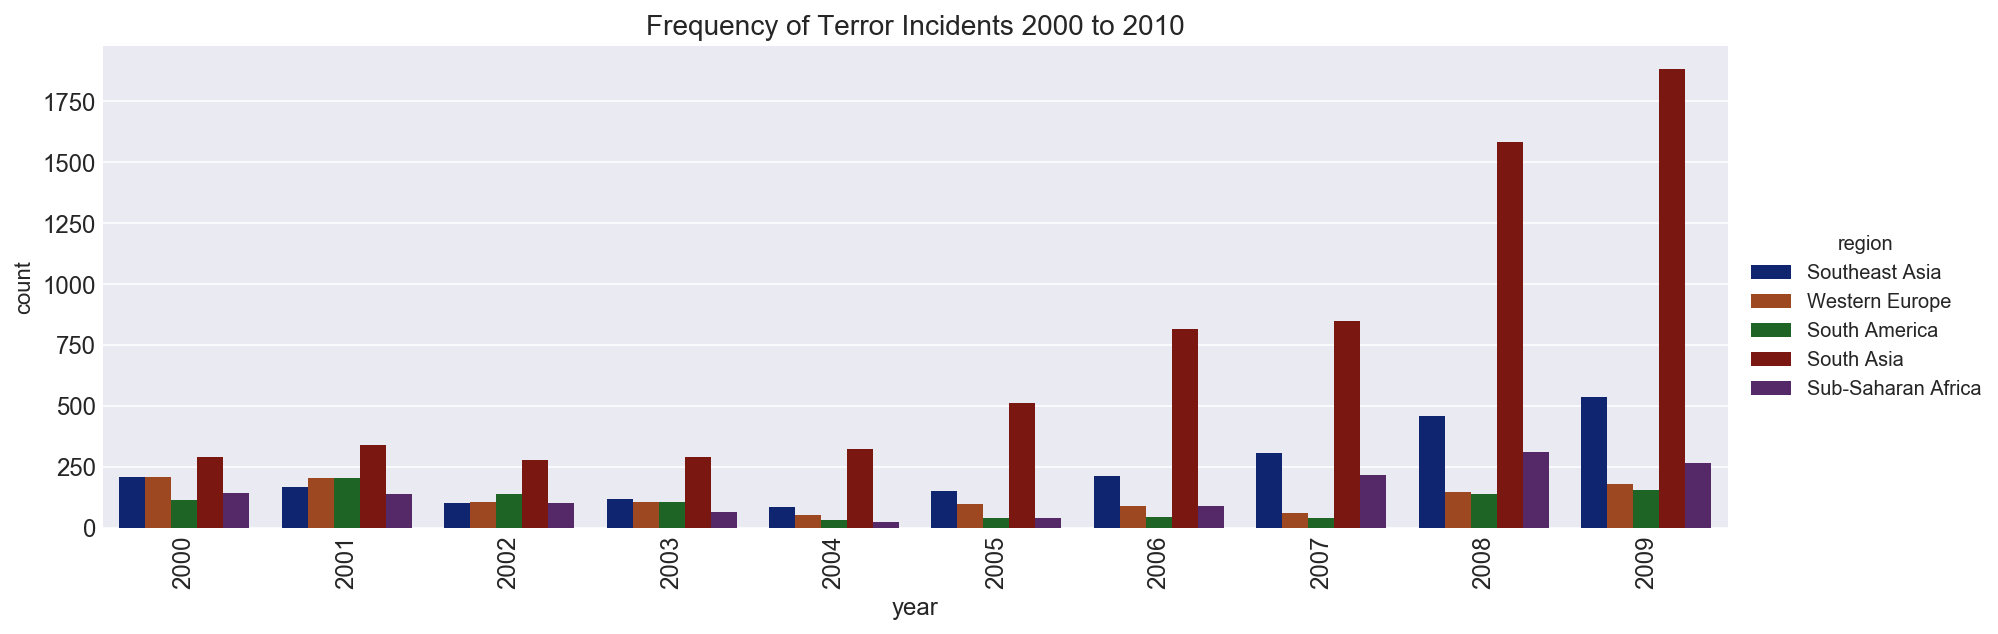

In [63]:
# Group active in identified top 5 regions, 2000-2010
top_5reg=df3[df3['region'].isin(df3['region'].value_counts()[1:6].index)]
# plot
sns.catplot("iyear", data=top_5reg, kind='count', hue='region', order=range(2000, 2010),height=4, aspect=3,palette='dark')

# cutomization
plt.xlabel('year',fontsize=12)
plt.xticks(rotation=90, size=12)
plt.ylabel('count',fontsize=11)
plt.yticks(size=12)
plt.title('Frequency of Terror Incidents 2000 to 2010',size=14)
plt.show();

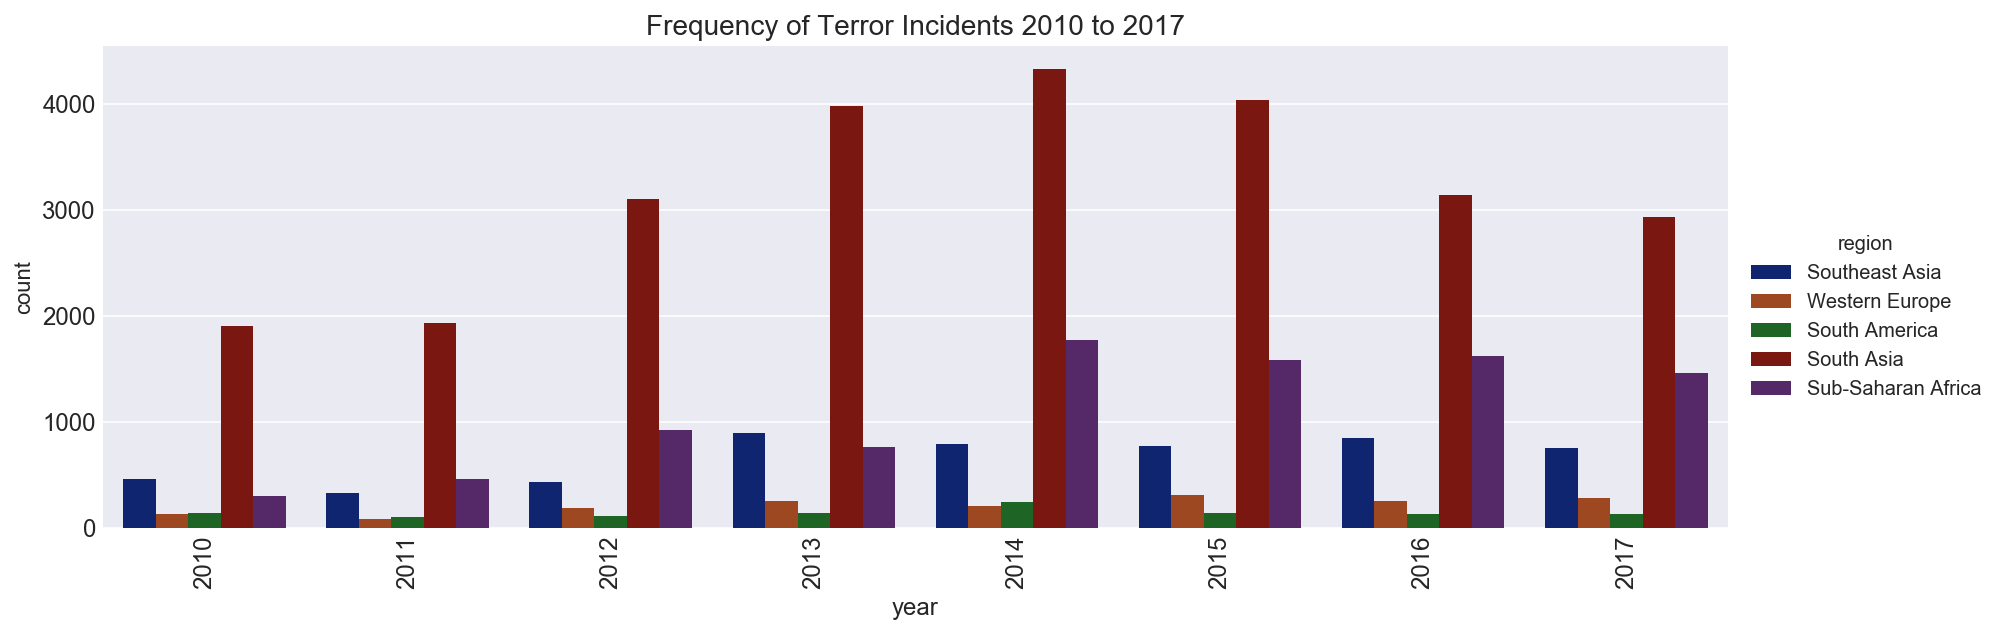

In [64]:
# Group active in id top 5 regions, 2010-2017
top_5reg=df3[df3['region'].isin(df3['region'].value_counts()[1:6].index)]
# plot
sns.catplot("iyear", data=top_5reg, kind='count', hue='region', order=range(2010, 2018),height=4, aspect=3,palette='dark')

# cutomization
plt.xlabel('year',fontsize=12)
plt.xticks(rotation=90, size=12)
plt.ylabel('count',fontsize=11)
plt.yticks(size=12)
plt.title('Frequency of Terror Incidents 2010 to 2017',size=14)
plt.show();

- Reviewing regions with most terror activity, we see that the overall top 5 regions remains unchanged from 2000 to recent years (2010-2017). Within these regions, South Asia increasingly accounts for more than half of terror activity of all other regions combined!

In [65]:
# What are the top 5 active groups in South Asia?
display(top_5reg.loc[top_5reg['region']=='South Asia']['gname'].value_counts()[:5])

unknown                                           17791
taliban                                            6298
communist party of india - maoist (cpi-maoist)     1814
maoists                                            1513
tehrik-i-taliban pakistan (ttp)                    1115
Name: gname, dtype: int64

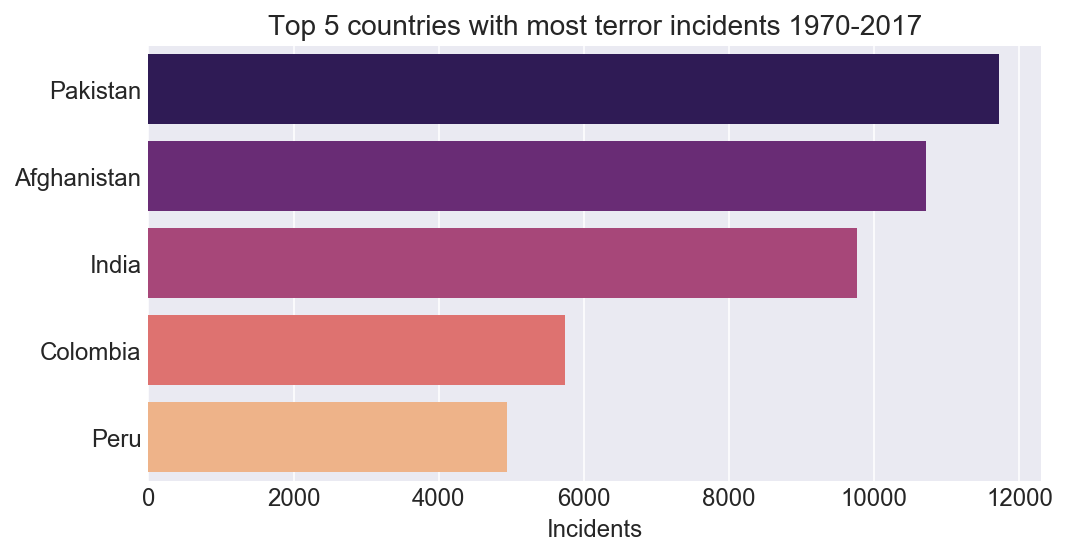

In [66]:
# Top 5 countries with most terror activities
# Skip index 0; attacks which unable to be attributed to particular group
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(top_5reg['country'].value_counts()[0:5].values,top_5reg['country'].value_counts()[0:5].index,\
            data=top_5reg,palette=('magma'));
# customization
plt.xlabel('Incidents',fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Top 5 countries with most terror incidents 1970-2017',size=14)
plt.show();

### Incidents by Motive (WordArt)

In the GTD, the `motive` data summarizes the intent of behind the behavior of the groups. When reports explicitly mention a specific motive for the attack, it is recorded in the GTD “Motive” field. It may include general information about the political, social, or economic climate at the time of the attack if considered relevant to the motivation underlying the incident. As this field is incorporated after 1997, only approx. 32,521 of 181,691 (18%) observations contain useful data on motive.

In this section, we analyse the motive using nlp techniques to 
- uncover insights to the motives behind terrorism, 
>A:  We uncovered that there is no single motivation for terrorism. It is a combination of several pre-disposing factors such as social as well as ideological goals. A common theme is sectarianism, in addition to acts of retaliation/ coercion.
- determine if there is a difference in motives between bombing & non-bombing attack modes,
- study the sentence structure to determine if there are any insights regarding entity recognition that may be valuable for HP tuning of classifier model. 

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [68]:
# Create a dataframe for the motive, drop those clearly unknown
df_word = df3.loc[df3['motive']!='unknown'].reset_index(drop=True).copy()
df_word.shape

(32521, 23)

In [69]:
mot_txt = df_word['motive']
mot_txt.head()

0       to protest the cairo illinois police deparment
1          to protest the war in vietnam and the draft
2          to protest the war in vietnam and the draft
3    suspected motives were to protest the vietnam ...
4    retaliation for the store owner who shot and k...
Name: motive, dtype: object

In [70]:
# leverage stopwords from wordcloud and nltk
# nltk stopwords
nlt_stop = stopwords.words('english')
# wordcloud stopwords
wc_stop = list(STOPWORDS)
# Use stopwords from wordcloud and nltk
stop = wc_stop+nlt_stop

In [71]:
# Instantiate countvectorizer
cvec = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=2)

In [72]:
# Create a dataframe with feature names = words
tf = pd.DataFrame(cvec.fit_transform(mot_txt).toarray(), columns=cvec.get_feature_names())

In [73]:
# Commented out for brevity
#tf.sum().sort_values(ascending=False).head()

From the list of common words, we observe that some of the words are not useful towards helping us in undercovering the true intent for these attacks. Examples are `motive`, `specific`, etc. We screen through the top 200 most common terms and remove similar words via stopwords for wordcloud, subsequent analyses and modeliing (as applicable). From analysis, the paired words from Bi-gram is not of much utility as compared to using Unigram. This is likely due to the style of phrasing practiced by the orgnanization maintaining the GTD. We set the n-gram range to Uni-gram to suit our analysis needs. 

In [74]:
# Note that word cloud input is not from count vectorizer per se. 
# customize own list of stopwords
own_stop = ['motive','specific','unknown','attack','sources','noted','claimed','stated','incident','targeted',\
            'responsibility','carried','suspected','larger','trend','speculated','posited','group','attacks',\
            'victims','related','forces','members','victim','area','taliban','occurred','accused','response',\
            'believed','united','day','national','assailants','maoists','recent','order','new','scheduled',\
            'note','anti','stating','operations','killed','2015','death','states','source','movement','intended',\
            'held','began','member','spokesperson','groups','called','working','time','personnel','2014','2013',\
            'statement','upcoming','release','leave','attempting','attacked','alleged','said','speculate',\
            'attempt','recently','days','led','reported','region','place','previously','practice','aimed','operating',\
            'believe','following','allegedly','pattern','previous','refused','country','used','prevent','took','opposed',\
            'ongoing','2017','according','prior','meant','identified','including','earlier','stop','designed','did','kill',\
            'part','wa','have']

In [75]:
# Extend the stopwords
stop.extend(own_stop)

Reference for word cloud and customization:
https://www.geeksforgeeks.org/generating-word-cloud-python/, https://www.datacamp.com/community/tutorials/wordcloud-python

In [76]:
# Tokenize the words
comment_words = '' 
# iterate through the txt 
for val in mot_txt: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

In [77]:
# Define function for word cloud plots
def cloud(source_text):
    # Word cloud
    wordcloud = WordCloud(width=1500, height=1000, background_color='black', max_words=800,\
                      stopwords=stop, max_font_size=100, min_font_size=20, random_state=42).generate(source_text) 
  
    # plot the WordCloud image    
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

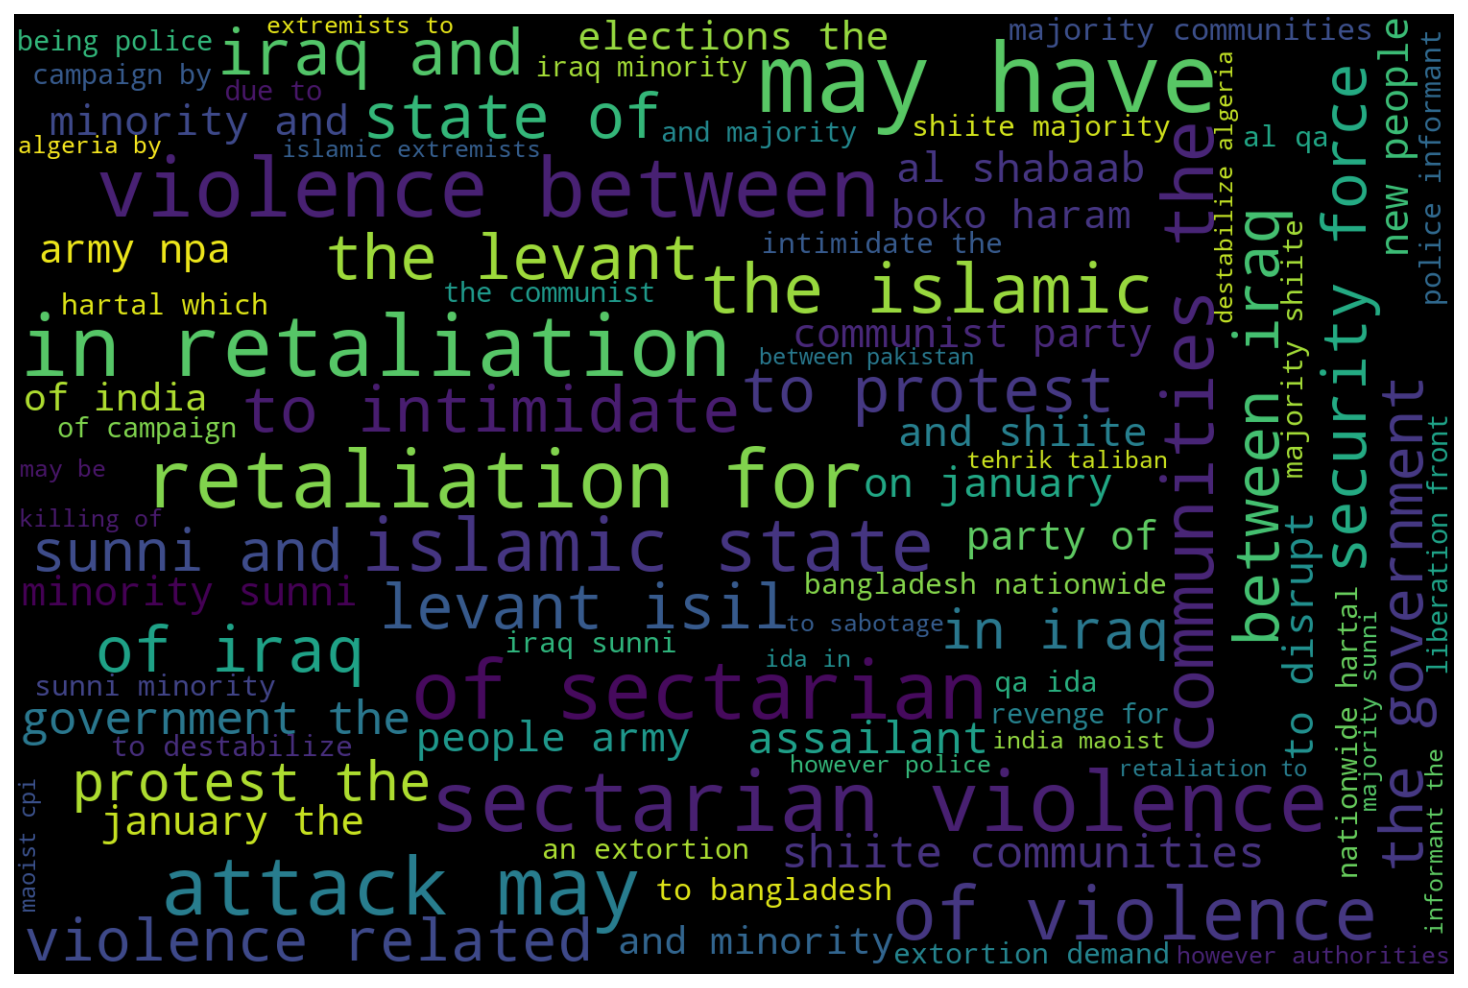

In [78]:
# Plot the word cloud
cloud(comment_words)

From the `motive` words presented in wordcloud, we can get a better sensing that there is no single motivation for terrorism. It is a combination of several pre-disposing factors such as social as well as ideological goals. A common theme from the words is "prejudice towards members of different backgrounds" as reflected by the word `sectarian`. Sectarianism is a form of prejudice, discrimination, or hatred arising from attaching relations of inferiority and superiority to differences between subdivisions within a group. We also observe that some of the attacks are to in response to similar attacks, while some are to coerce the target party into acceding to demands (words like extortion, demand).

The words also hinted that terror incidents are mostly confined to local regions; against their local government, political or religious counterparts. Throughout the Cold War, insurgents have kept their struggles local, even though they fought as proxies of foreign powers (ref:"The rise and fall of AQ, F.A.Gerges). International terrorism such as the unfortunate Sep 11 attacks represents all the more significant coordination from strategic planning to execution. 

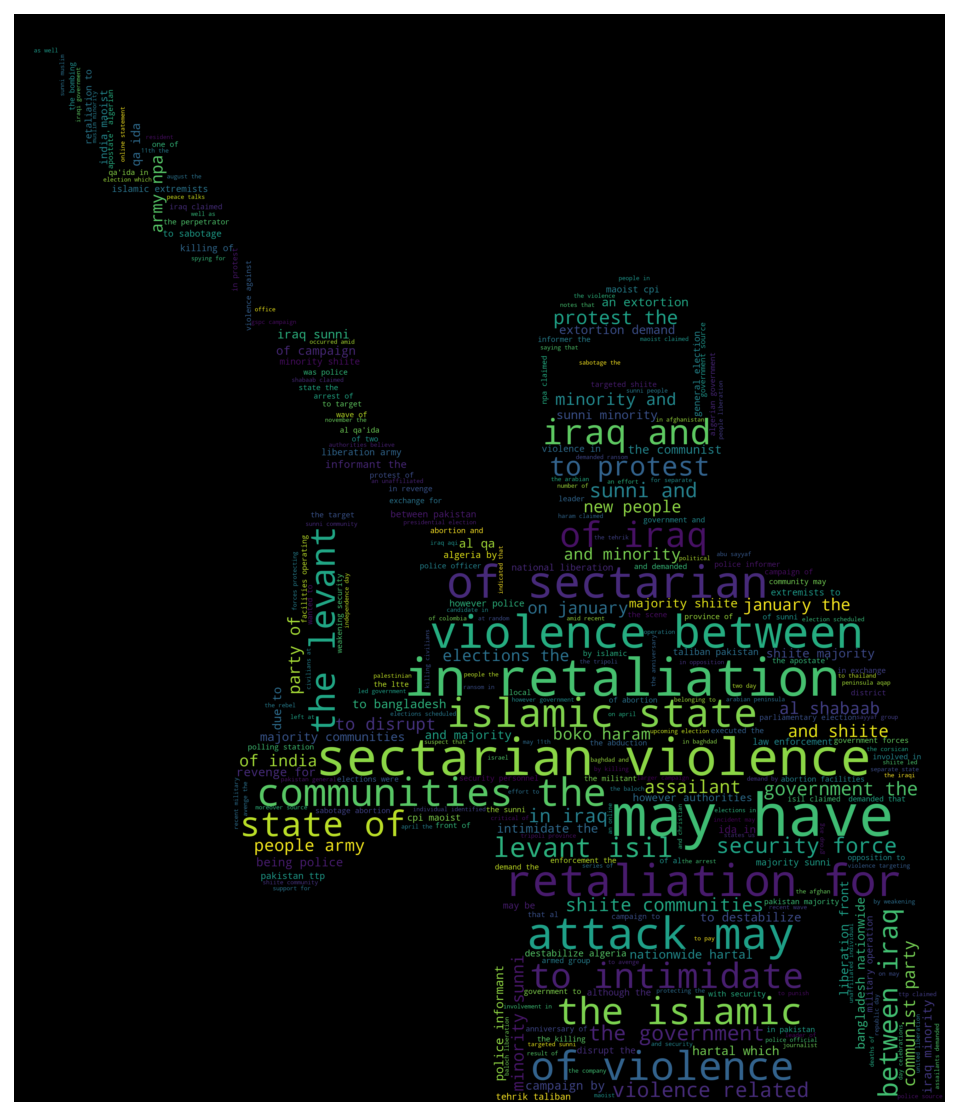

In [79]:
# Mini exercise to add Custom mask to word cloud
# Import mask image
t_mask = np.array(Image.open("../misc/t_clipart.jpg"))
wc = WordCloud(background_color="black", max_words=300, mask=t_mask,
               stopwords=stop, contour_width=2, contour_color='black')
wc.generate(comment_words)
# Plot alternate word art
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Study the motive words between bombing and non-bomb attack modes.

In [80]:
# Assessment on bombing proportion
# Bombing proportion (motive known & motive unknown)
print(f"Bombing proportion; motive(known & unknown): {round(df3.loc[df3['atkmode']=='bombing'].shape[0]/df3.shape[0],2)}")
# Bombing proportion (motive unknown)
print(f"Bombing proportion; motive(known): {round(df_word.loc[df_word['atkmode']=='bombing'].shape[0]/df_word.shape[0],2)}")

Bombing proportion; motive(known & unknown): 0.54
Bombing proportion; motive(known): 0.48


In [81]:
# Sub dataframes for bomb and non-bomb attack modes
df_wordb = df_word.loc[df_word['atkmode']=='bombing'].copy()
df_wordnb = df_word.loc[df_word['atkmode']!='bombing'].copy()

In [82]:
# Review the motive (bombing) words in brief
mot_txtb = df_wordb['motive']
mot_txtb.head()

3     suspected motives were to protest the vietnam ...
5     the incident took place during disturbances be...
6     the incident took place during heightened anti...
8     the attack occurred during the violent iowa be...
10    african american opposition to the school inte...
Name: motive, dtype: object

In [83]:
# Review the motive (non-bombing) words in brief
mot_txtnb = df_wordnb['motive']
mot_txtnb.head()

0       to protest the cairo illinois police deparment
1          to protest the war in vietnam and the draft
2          to protest the war in vietnam and the draft
4    retaliation for the store owner who shot and k...
7                  intimidate the black panther party.
Name: motive, dtype: object

In [84]:
# Tokenize the words
comment_wordsb = '' 
# iterate through the txt 
for val in mot_txtb: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_wordsb += " ".join(tokens)+" "

In [85]:
# Tokenize the words
comment_wordsnb = '' 
# iterate through the txt 
for val in mot_txtnb: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_wordsnb += " ".join(tokens)+" "

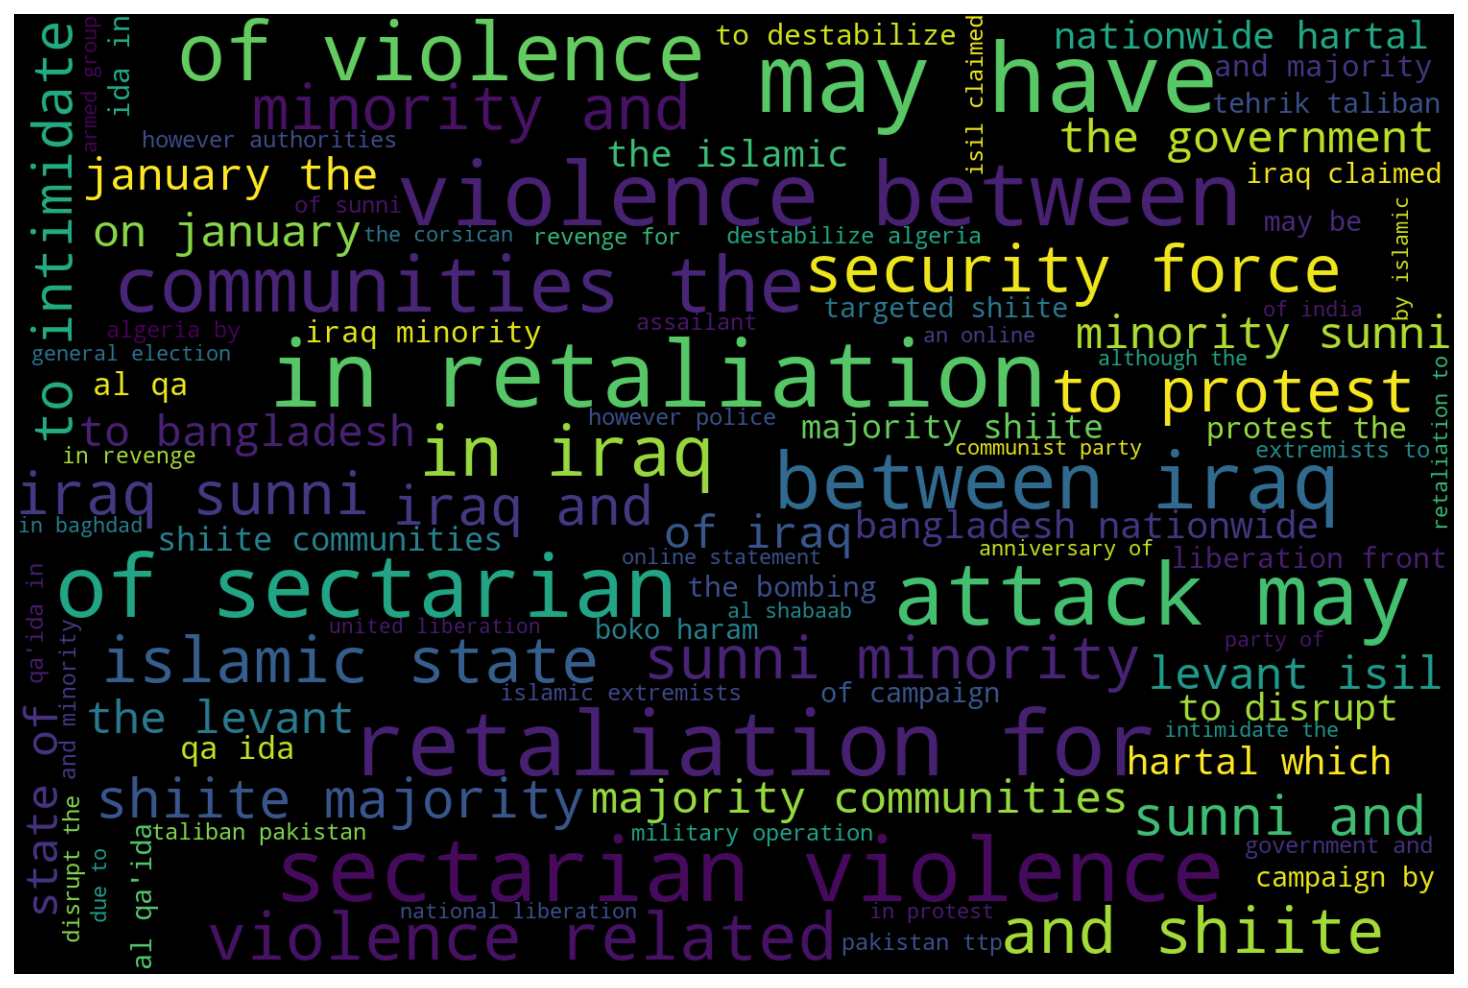

In [86]:
# Motive words (bomb)
cloud(comment_wordsb)

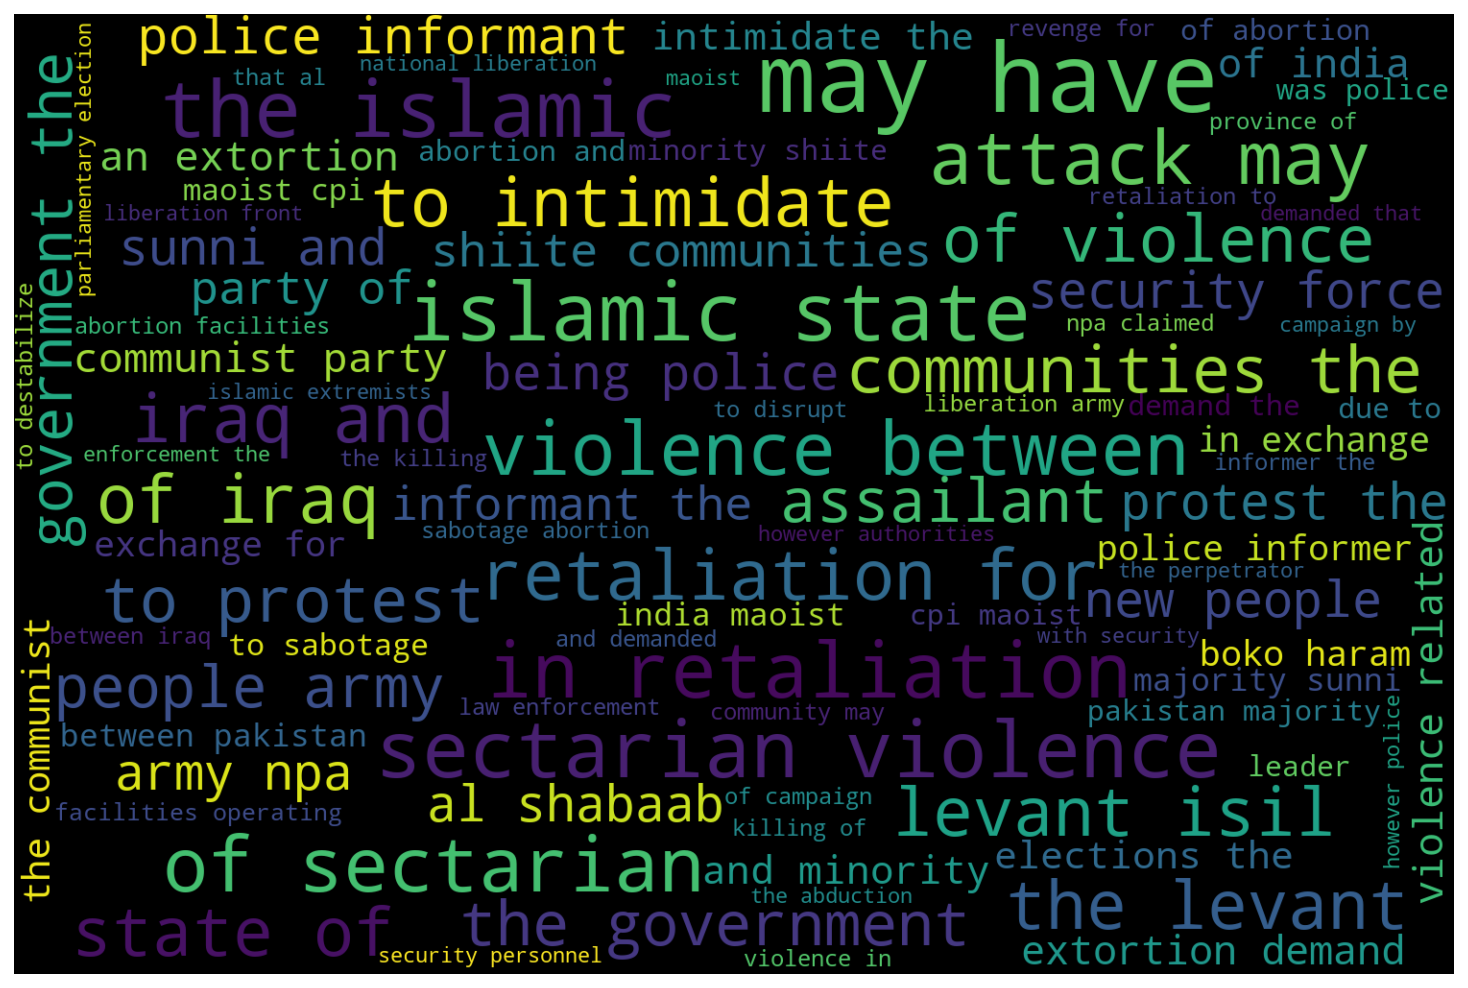

In [87]:
# Motive words (bomb)
cloud(comment_wordsnb)

There is significant overlap in the motive words between bomb and non-bomb attack modes, such as group names: `islamic state`, `levant isil`, location: `iraq`, sectarian: `sunni`, `communities`. One subtle difference between the two word clouds is the end-objectives: 
- for `bombing`, the end-objective seems to be destablise governments
- for `non-bombing`, the end-objective seems to be related to protests, retaliations. 

### EDA (Keywords)

Building good performing classifers from data with easily separable classes is relatively straightforward but care should be exercised to determine if such data is representative of the actual world environment. Samples from different classes seldom share similar characteristics, or are overlapped most of the time in the real world environment (as seen in the overlapping words in wordcloud). This means the boundaries of each class may not be clearly defined as desired. 

Common practices to address this problem includes:
- i) modifying the original data by introducing/removing features which decrease the overlapping region,
- ii) adapting algorithms to reduce the negative impact of overlapping features.

Wordart provided a general sense of the prevalent key words among the bomb and non-bomb motive text. This section explores their distribution. These insights could be useful to fine-tune the subsequent models.

In [88]:
# Vectorize the motive text from df_wordb, and df_wordnb
tfb = pd.DataFrame(cvec.fit_transform(df_wordb['motive']).toarray(), columns=cvec.get_feature_names())
tfnb = pd.DataFrame(cvec.fit_transform(df_wordnb['motive']).toarray(), columns=cvec.get_feature_names())

In [89]:
# No.of features fitted
print(f"Features fitted for bomb motive text: {tfb.shape}")
print(f"Features fitted for non-bomb motive text: {tfnb.shape}")

Features fitted for bomb motive text: (15496, 3832)
Features fitted for non-bomb motive text: (17025, 5030)


In [90]:
# check value counts
display(tfb.sum().sort_values(ascending=False).head(10))
display(tfnb.sum().sort_values(ascending=False).head(10))

attack            12528
motive            12402
specific          12231
unknown           11887
sources            3182
claimed            1362
violence           1287
responsibility     1223
noted              1206
iraq               1177
dtype: int64

motive      12990
specific    12879
unknown     12323
attack      10972
sources      5240
noted        1773
targeted     1763
stated       1755
incident     1632
claimed      1602
dtype: int64

In [91]:
# word counts of bomb text and non-bomb motive text
"""Merge the two dataframes on Outer join, align with both dataframe indexes."""
word_counts = pd.merge(pd.DataFrame(data=tfb.sum().sort_values(ascending=False)),\
                       pd.DataFrame(data=tfnb.sum().sort_values(ascending=False)),\
                       how='outer',left_index=True,right_index=True)
# rename columns
word_counts.columns = ['bomb', 'non-bomb']

In [92]:
# view the df to ensure correct column naming
word_counts.head(2)

bomb  non-bomb
000   7.0      17.0
01    2.0       7.0

In [93]:
# Find sum of word counts between both bomb and non-bomb text
word_counts['sum'] = word_counts['bomb'] + word_counts['non-bomb']
# Sort by most occurrence to least occurrence
word_counts.sort_values(['sum'], ascending=False).head(10)

bomb  non-bomb      sum
motive    12402.0   12990.0  25392.0
specific  12231.0   12879.0  25110.0
unknown   11887.0   12323.0  24210.0
attack    12528.0   10972.0  23500.0
sources    3182.0    5240.0   8422.0
noted      1206.0    1773.0   2979.0
claimed    1362.0    1602.0   2964.0
stated     1081.0    1755.0   2836.0
incident   1177.0    1632.0   2809.0
targeted   1002.0    1763.0   2765.0

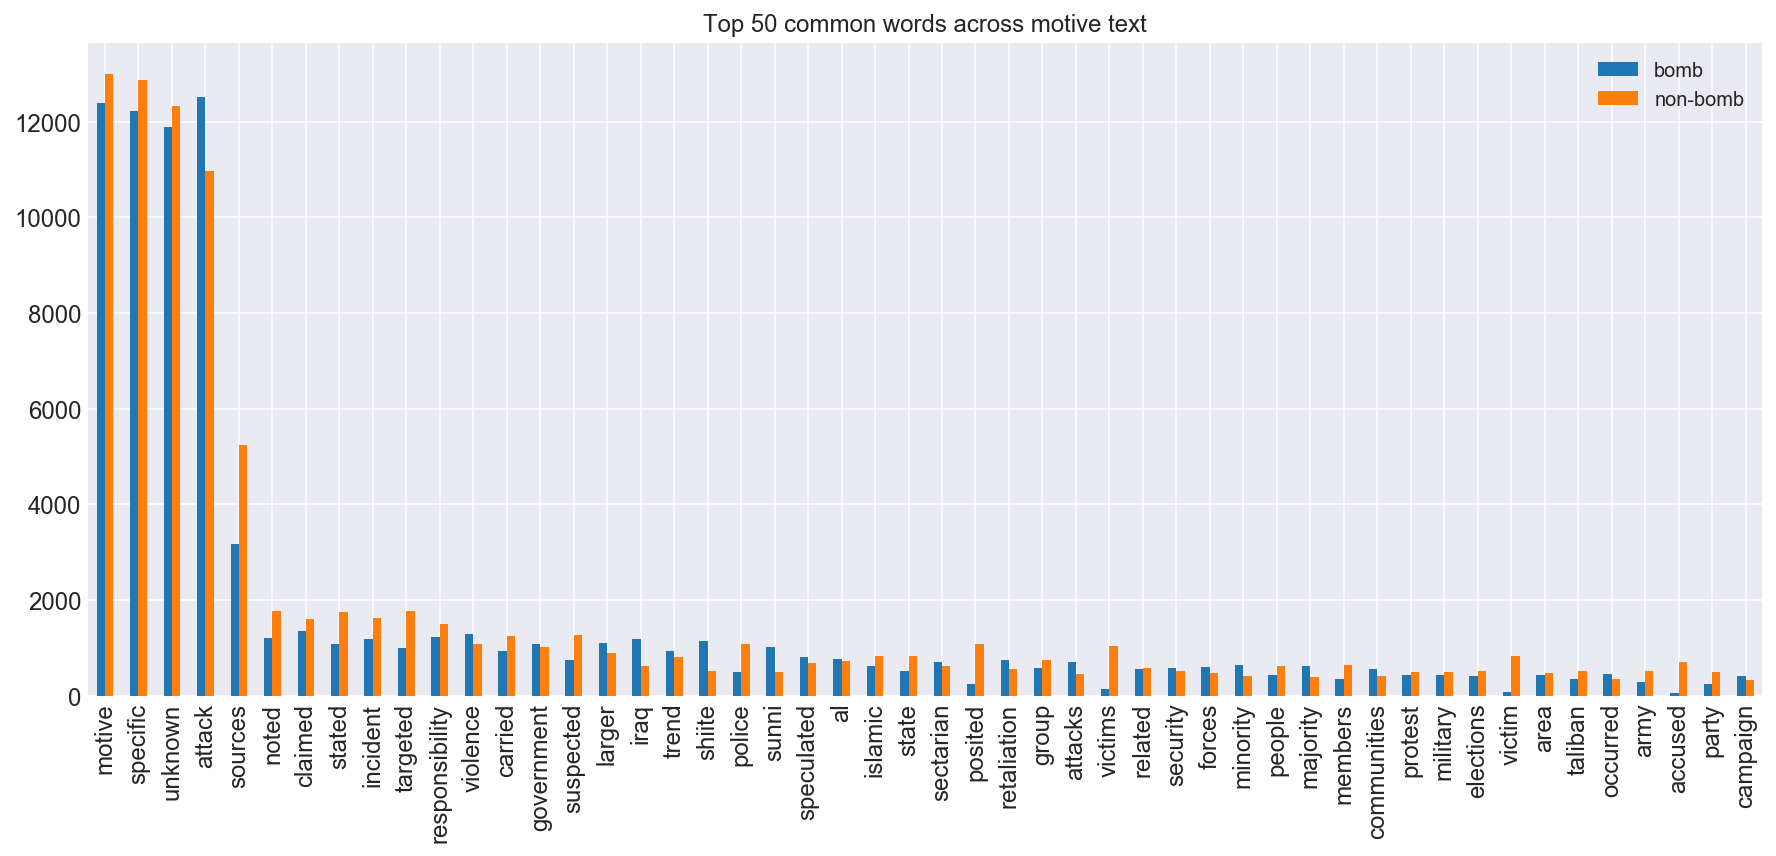

In [94]:
# Plot 30 most used words
word_counts.sort_values(['sum'], ascending=False).drop('sum', axis=1).head(50).\
plot(kind='bar',figsize=(15,6),fontsize=12,title='Top 50 common words across motive text');

To improve generalizability of the model, 
- identify the significant occurring words that don't add to meaningful classification We decided on 15 words: 'motive','specific','unknown','attack','sources','noted','claimed','stated','incident','targeted','responsibility','violence','carried','government','suspected'.

- identify common words that have significant overlaps. 

In [95]:
print(f"bomb motive total entries: {tfb.shape[0]}, word count: {word_counts['bomb'].sum()}")
print(f"non-bomb motive total entries: {tfnb.shape[0]}, word count: {word_counts['non-bomb'].sum()}")

bomb motive total entries: 15496, word count: 143755.0
non-bomb motive total entries: 17025, word count: 165410.0


In [96]:
#Find words with 
# 1. significant overlaps
# 2. measure by gap (difference of word count between bomb & non-bomb class)
# 3. identify the more significant occuring ones by population proportion
word_counts['gap'] = abs(word_counts['bomb'] - word_counts['non-bomb'])
# sort by most used values
word_counts.sort_values(['sum'], ascending=False).loc[(word_counts['sum']>1000) & (word_counts['gap']<200)]

bomb  non-bomb     sum    gap
government   1091.0    1013.0  2104.0   78.0
trend         944.0     815.0  1759.0  129.0
speculated    819.0     682.0  1501.0  137.0
al            758.0     716.0  1474.0   42.0
sectarian     712.0     623.0  1335.0   89.0
retaliation   744.0     569.0  1313.0  175.0
group         574.0     738.0  1312.0  164.0
related       558.0     586.0  1144.0   28.0
security      585.0     510.0  1095.0   75.0
forces        598.0     479.0  1077.0  119.0
people        430.0     612.0  1042.0  182.0

In [97]:
# Prelim list of stop words for modeling (to be used in P5.1)
own_stop = ['motive','specific','unknown','attack','sources','noted', 'claimed','stated','incident','targeted',\
            'responsibility','violence','carried','government','suspected','trend','speculated','al','sectarian',\
            'retaliation','group','related','security','forces','people','bomb','bombing','bombings']

### spaCy Dependency and Entity Recognition
- Utilize spaCy to help us better understand the word structure of the `motive` content.
- From analysis, able to infer existence of structured approach and discipline towards entering of `motive` data (i.e. same word length generally infers the same set of motive description.
- The motive words is generally structured as Context, Group name, Goal of attack, Further sources or information to support context.

In [98]:
# Import library, load web english (drawn from english words of websites)
import spacy
sp = spacy.load('en_core_web_sm')
from spacy import displacy

In [99]:
# Reset index for the motive words (bomb and non-bomb) attack modes
mot_txtb = mot_txtb.reset_index(drop=True)
mot_txtnb = mot_txtnb.reset_index(drop=True)

In [100]:
# Sort by longest phrases
# Simply using ,sort_values() only returns the content, sorted by alphabet order.
mot_txtb.str.len().sort_values(ascending=False)[:15]

11230    863
11397    561
11400    561
11393    561
11392    561
11390    561
11394    561
11391    561
11396    561
11404    561
11398    561
11395    561
11401    561
15304    552
15309    552
Name: motive, dtype: int64

In [101]:
mot_txtnb.str.len().sort_values(ascending=False)[:5]

11073    774
10694    734
281      697
12669    674
10460    596
Name: motive, dtype: int64

It is observed that there is a structured approach and discipline towards entering of `motive` data (i.e. same word length generally infers the same set of motive description. For bombing `motive` texts, I had to expand display list in order to find the next indexed entry with a different content. 

In [102]:
# Extract motive words (three sets each from bomb / non-bomb attack mode)

In [103]:
# Select and display the three motive texts for bombing 
display(mot_txtb[11230])
display(mot_txtb[11397])
display(mot_txtb[15304])

"according to a claim of responsibility purportedly made by the movement for the emancipation of the niger delta (mend), the attack was the first in a campaign to make themselves known, end oil production in nigeria, and drive out oil companies. the asserted goal was the realization of a more equitable distribution of national oil wealth, particularly for citizens living in the niger delta region. the claim maintained that they had been warning citizens about nigerian leadership, especially president goodluck jonathan, whom they accused of wasting public funds and failing to address the nation's and citizens' hardships. furthermore, south african interests were threatened due to allegations that president jacob zuma interfered with efforts to achieve more equitable distribution of wealth and because an alleged mend leader was imprisoned in the country."

"the haqqani network clamed responsibility for the incident and stated that the attack was part of a larger pattern of violence designed to mark the start of the group's spring offensive.  mujahid claimed that the 18-hour offensive was in revenge for actions by american military forces, including the murder of 17 civilians by a united states (us) soldier and the burning of korans at a military base.  the spokesperson also claimed the attacks were designed to be a message in direct response to foreign commanders who claimed that the group had lost momentum."

"the arakan rohingya salvation army (arsa) claimed responsibility for the incident and stated that the attack was carried out in response to actions taken by government forces in rakhine, including killing and sexually assaulting members of the community. sources also posited that the attack coincided with the publication of the advisory commission on rakhine state report and united nations (un) meetings. moreover, sources also suspected that the attack was part of a larger trend of violence between myanmar's muslim minority and buddhist majority."

In [104]:
# Select and display the three motive texts for non-bombing 
display(mot_txtnb[774])
display(mot_txtnb[734])
display(mot_txtnb[697])

'part of a campaign by islamic extremists to intimidate algerian civilians from participating in secular activities.'

'specific motive is unknown, but sources speculate that the assailants were anti-islamic terrorists'

'sources indicated that the npa wanted to avenge the series of recent defeats by philippines government forces.'

In [105]:
# Pass in the words into spaCy
sen_b1 = sp(mot_txtb[11230])
sen_b2 = sp(mot_txtb[11397])
sen_b3 = sp(mot_txtb[15304])
sen_nb1 = sp(mot_txtnb[774])
sen_nb2 = sp(mot_txtnb[734])
sen_nb3 = sp(mot_txtnb[697])
sen_blist = [sen_b1, sen_b2, sen_b3]
sen_nblist = [sen_nb1, sen_nb2, sen_nb3]

In [106]:
# Word struture of motive
# Use a less verbose text for analysis
displacy.render(sen_nb1, style='dep', jupyter=True, options={'distance':100, 'compact':False,'bg':'black','color':'white'})

The motive words is generally structured as follows:
- 1. Context (describes if part of series of events with source citation. If unknown, sources for hypothesis is stated.
- 2. Group name (either claimed or identified by sources)
- 3. Goal of attack
- 4. Further sources or information to support context.

In [107]:
# Another one for analysis
displacy.render(sen_nb3, style='dep', jupyter=True, options={'distance':100, 'compact':False,'bg':'black','color':'white'})

In [108]:
# Entity recognition for bomb motives
for i in range(len(sen_blist)):
    displacy.render(sen_blist[i], style='ent', jupyter=True)

In [109]:
# Entity recognition for non-bomb motives
for i in range(len(sen_nblist)):
    displacy.render(sen_nblist[i], style='ent', jupyter=True)

- spaCy visualisation highlighted contextual entities (helps guide readers' understanding).
- Interestingly, one particular entry has no entities annotate, (non-bomb second example, due to the choice of words used to describe pepertrators in general (inferred that there is insufficient data to ascribe responsibility to a particular terror group. 
- NORP; Nationalities or religious or political groups, GPE; Nationalities or religious or political groups. (Ref: https://spacy.io/api/annotation)

### Feature Engineering
- Engineer a feature to turn atkmode into a 1/0 column, where 1 indicates bomb.

In [110]:
display(df_word.head(2))
print()
print(f"Reviewing types of atkmode: {df_word['atkmode'].unique()}")

eventid  iyear  imonth  iday        country         region        lat  \
0  197001010002   1970       1     1  United States  North America  37.005105   
1  197001020003   1970       1     2  United States  North America  43.076592   

         lon  crit1  crit2  crit3  success  suicide          atkmode  \
0 -89.176269      1      1      1        1        0    armed assault   
1 -89.412488      1      1      1        1        0  facility attack   

   targtype        targnat               gname  \
0    police  united states  black nationalists   
1  military  united states     new year's gang   

                                           motive  indiv    weaptype  nkill  \
0  to protest the cairo illinois police deparment      0    firearms      0   
1     to protest the war in vietnam and the draft      0  incendiary      0   

   nwound  property  
0       0         1  
1       0         1


Reviewing types of atkmode: ['armed assault' 'facility attack' 'bombing' 'assassination' 'hijack'
 'unarmed assault' 'hostage kidnap' 'hostage taking' 'unknown']


In [111]:
# Feature engineer atkmode
mode_dummy = pd.get_dummies(df_word['atkmode'])
# Drop the rest except bombing column
mode_dummy.drop(['armed assault','assassination','facility attack','hijack','hostage kidnap','hostage taking',\
                 'unarmed assault','unknown'],inplace=True, axis=1)
# Rename column
mode_dummy.columns=['bomb']

In [112]:
# Add the feature to df_word
df_word = pd.concat([df_word, mode_dummy], axis=1)
df_word.head(5)

eventid  iyear  imonth  iday        country         region        lat  \
0  197001010002   1970       1     1  United States  North America  37.005105   
1  197001020003   1970       1     2  United States  North America  43.076592   
2  197001030001   1970       1     3  United States  North America  43.072950   
3  197001120001   1970       1    12  United States  North America  40.697132   
4  197001130001   1970       1    13  United States  North America  47.610786   

          lon  crit1  crit2  crit3  success  suicide          atkmode  \
0  -89.176269      1      1      1        1        0    armed assault   
1  -89.412488      1      1      1        1        0  facility attack   
2  -89.386694      1      1      1        1        0  facility attack   
3  -73.931351      1      1      1        1        0          bombing   
4 -122.331306      1      1      1        1        0  facility attack   

    targtype        targnat               gname  \
0     police  united states  black nationalists   
1   military  united states     new year's gang   
2    general  united states     new year's gang   
3  education  united states  black nationalists   
4   business  united states  black nationalists   

                                              motive  indiv    weaptype  \
0     to protest the cairo illinois police deparment      0    firearms   
1        to protest the war in vietnam and the draft      0  incendiary   
2        to protest the war in vietnam and the draft      0  incendiary   
3  suspected motives were to protest the vietnam ...      0  explosives   
4  retaliation for the store owner who shot and k...      0  incendiary   

   nkill  nwound  property  bomb  
0      0       0         1     0  
1      0       0         1     0  
2      0       0         1     0  
3      0       0         1     1  
4      0       0         1     0

In [113]:
# Save current cleaned & feature engineered dataset
# commented out to freeze data update
#df_word.to_csv('../assets/wordok.csv')

---